### LTFS Top-Up Upsell Prediction 

#### Part 1 : Convert XLSX to CSV

In [ ]:
!pip install shap

In [ ]:
!pip install colorama

In [ ]:
!pip install catboost

In [ ]:
!pip install category_encoders

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as stats
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import colorama  # https://pypi.python.org/pypi/colorama
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll
import category_encoders as ce
import pickle
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import os
from collections import Counter

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_Data.xlsx')
train_data.head()

ID Frequency InstlmentMode  ...           State   ZiPCODE       Top-up Month
0   1   Monthly        Arrear  ...  MADHYA PRADESH  464993.0        > 48 Months
1   2   Monthly       Advance  ...  MADHYA PRADESH  466001.0  No Top-up Service
2   3   Quatrly        Arrear  ...  MADHYA PRADESH  462030.0       12-18 Months
3   7   Monthly       Advance  ...  MADHYA PRADESH  473335.0        > 48 Months
4   8   Monthly        Arrear  ...     CHATTISGARH  495442.0       36-48 Months

[5 rows x 26 columns]

In [ ]:
train_data.shape

(128655, 26)

In [ ]:
train_data.to_csv("train_data.csv", sep='|', index=False)

In [ ]:
train_bureau = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_bureau.xlsx')
train_bureau.head()

ID  SELF-INDICATOR  ...                        AMT PAID - HIST TENURE
0   1           False  ...                                     ,,    NaN
1   1           False  ...                 ,,,,,,,,,,,,,,,,,,,,,,   36.0
2   1            True  ...                                 ,,,,,,    NaN
3   1            True  ...  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,    NaN
4   1            True  ...  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,    NaN

[5 rows x 25 columns]

In [ ]:
train_bureau.to_csv("train_bureau.csv", sep='|', index=False)

In [ ]:
test_data = pd.read_excel("/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx")
test_data.to_csv("test_data.csv", sep='|', index=False)
test_bureau = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_bureau.xlsx')
test_bureau.to_csv("test_bureau.csv", sep='|', index=False)

### Part 2 : Adversarial Validation

There are chances that the patterns in the dataset differ. In such cases performing cross-validation will not help in solving the overfitting problem because the data for validation comes from the training set. To overcome these problems, adversarial validation is used. 

Overcome overfitting with adversarial validation

The idea behind this is to identify the degree of similarity between the training and test data by analysing feature distribution.

To do this, we build a classifier to predict which data is from the training set and which is from the test set. This model will assign 0 for rows from the train set and 1 for rows of data from the test set. If there are differences between the distributions of train and test set then this classifier will be able to identify these

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/train_data.csv", sep='|')
train_bureau = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/train_bureau.csv", sep='|')

test_data = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/test_data.csv", sep='|')
test_bureau = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/test_bureau.csv", sep='|')

In [ ]:
train_data = train_data.drop('Top-up Month', axis=1)
cat_cols = list(train_data.select_dtypes('object').columns)
cat_cols

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'SEX',
 'City',
 'State']

In [ ]:
for col in train_data.columns:
    if col not in cat_cols:
        print(col)

ID
BranchID
Tenure
AssetCost
AmountFinance
DisbursalAmount
EMI
AssetID
ManufacturerID
SupplierID
LTV
AGE
MonthlyIncome
ZiPCODE


##### Fill Missing Values

In [ ]:
for col in cat_cols:
    if col != 'Top-up Month':
        print(col)
        train_data[col] = train_data[col].fillna('UNK')
        test_data[col] = test_data[col].fillna('UNK')

Frequency
InstlmentMode
LoanStatus
PaymentMode
Area
DisbursalDate
MaturityDAte
AuthDate
SEX
City
State


In [ ]:
for col in ['AGE', 'MonthlyIncome', 'ZiPCODE', 'ManufacturerID']:
    print(col)
    train_data[col] = train_data[col].fillna(-999)
    test_data[col] = test_data[col].fillna(-999)

AGE
MonthlyIncome
ZiPCODE
ManufacturerID


In [ ]:
features = list(train_data.columns)
target = 'dataset_label'
train_data['dataset_label'] = 0
test_data['dataset_label'] = 1

##### Put 0 in Train_data and 1 in Test_data

In [ ]:
display(train_data.head())
display(test_data.head())

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       UNK   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       UNK   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465            1568       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175            1062       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146            1060      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591            1060       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320            1046       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  dataset_label  
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0              0  
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0              0  
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0              0  
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0              0  
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0              0

ID    Frequency InstlmentMode LoanStatus PaymentMode  BranchID     Area  \
0    4      Monthly       Advance     Closed       PDC_E         2     GUNA   
1    5      Monthly       Advance     Closed         PDC         2     GUNA   
2    6      Quatrly        Arrear     Closed         PDC         2     GUNA   
3   25  Half Yearly        Arrear     Closed      Billed       154      UNK   
4  119      Quatrly        Arrear     Closed         PDC       194  CUTTACK   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      46     480000       365000.0         365000.0   1000.0    2011-12-29   
1      45     480000       285000.0         285000.0   9300.0    2012-04-28   
2      48     580000       400000.0         400000.0  35800.0    2013-10-22   
3      36     725000       500000.0         500000.0  52000.0    2013-05-21   
4      48     617000       400000.0         400000.0  35400.0    2012-11-30   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2015-10-05  2011-12-29   3524747          1046.0       22354  75.83   M   
1   2016-01-01  2012-04-28   4985862          1046.0       22354  57.44   M   
2   2017-09-10  2013-10-22  12881783          1060.0       65929  68.97   M   
3   2016-02-10  2013-05-21  10613776          1049.0       68597  61.79   M   
4   2016-12-05  2012-11-30   7911110          1049.0       38493  59.09   M   

    AGE  MonthlyIncome            City           State   ZiPCODE  \
0  50.0       32069.00            GUNA  MADHYA PRADESH  473001.0   
1  35.0       25000.00            GUNA  MADHYA PRADESH  473001.0   
2  37.0       23333.33            GUNA  MADHYA PRADESH  473001.0   
3  55.0       91666.67      MAHASAMUND     CHATTISGARH  493558.0   
4  48.0       12500.00  JAGATSINGHAPUR          ORISSA  754137.0   

   dataset_label  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
all_cols = features + [target]
all_cols

['ID',
 'Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'BranchID',
 'Area',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'EMI',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'AssetID',
 'ManufacturerID',
 'SupplierID',
 'LTV',
 'SEX',
 'AGE',
 'MonthlyIncome',
 'City',
 'State',
 'ZiPCODE',
 'dataset_label']

In [ ]:
def create_adversarial_data(df_train, df_test, cols, N_val=10000):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    ## We will do random sampling of combined dataframe of N_val , replace = False -- no repeat
    adversarial_test = df_master.sample(N_val, replace=False)
    ## Will make adversarial_train dataset which is not in adversarial_test
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

In [ ]:
train_data.shape , test_data.shape

((128655, 26), (14745, 26))

In [ ]:
adversarial_train, adversarial_test = create_adversarial_data(train_data, test_data, all_cols, 20000)
adversarial_train.shape, adversarial_test.shape

((120068, 26), (20000, 26))

In [ ]:
cat_cols

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'SEX',
 'City',
 'State']

#### Cat Boost Classifier

Pool used in CatBoost as a data structure to train model from.

In [ ]:
adversarial_train.head(2)

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID  Area  \
2   3   Quatrly        Arrear     Active  Direct Debit         1   UNK   
3   7   Monthly       Advance     Closed        Billed       125  GUNA   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  dataset_label  
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0              0  
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0              0

In [ ]:
target

'dataset_label'

In [ ]:
features

['ID',
 'Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'BranchID',
 'Area',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'EMI',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'AssetID',
 'ManufacturerID',
 'SupplierID',
 'LTV',
 'SEX',
 'AGE',
 'MonthlyIncome',
 'City',
 'State',
 'ZiPCODE']

In [ ]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=cat_cols
)

params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
#     'task_type': 'GPU', # if you have GPU
    'devices': '2', 
}

In [ ]:
model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

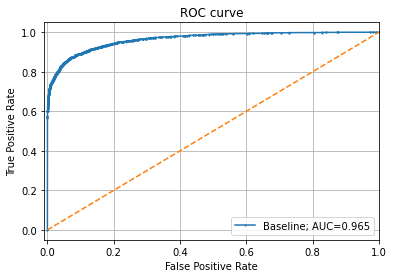

In [ ]:
plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

The above graph indicates that AUC value is 0.965 which means the model is working really well. But remember that the better the model performs, the more distributed our data is. Which means the train and test sets have a lot of variation and a machine learning model would perform poorly on the test set due to overfitting. 


#### So our aim in Adversarial Validation is to create weaker Model with low AUC Score

By plotting the graph of features we can identify the most important feature. 

In [ ]:
def plot_importances(model, holdout_data, features):
    explainer = shap.TreeExplainer(model)

    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')

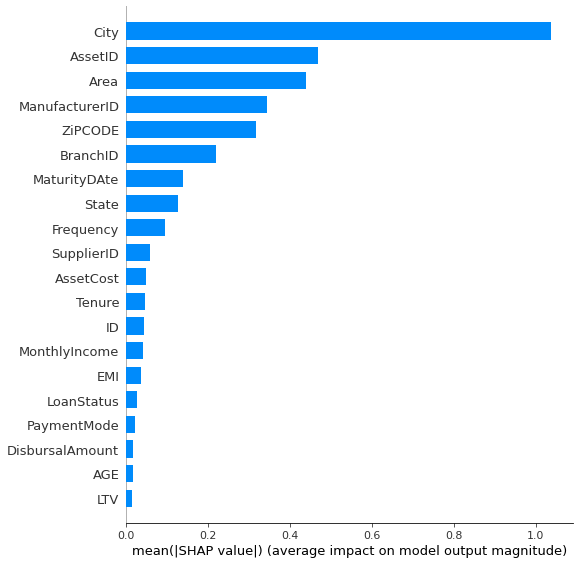

In [ ]:
plot_importances(model, holdout_data, features)

With this information, we can go ahead and try dropping a few features and evaluating our model again. Our aim is to make it as difficult as possible for the adversarial classifier to classify between train and test points. 

Here, I have dropped the first column City to see how it impacts our classification model. 

In [ ]:
params

{'devices': '2',
 'eval_metric': 'AUC',
 'iterations': 100,
 'od_type': 'Iter',
 'od_wait': 50}

In [ ]:
params2 = dict(params)
params2.update({"ignored_features": ['City']})
params2

{'devices': '2',
 'eval_metric': 'AUC',
 'ignored_features': ['City'],
 'iterations': 100,
 'od_type': 'Iter',
 'od_wait': 50}

In [ ]:
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

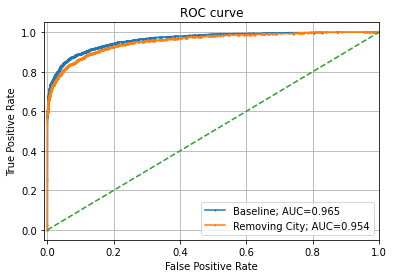

In [ ]:
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model2.predict_proba(holdout_data)[:,1]],
    ['Baseline', 'Removing City']
)

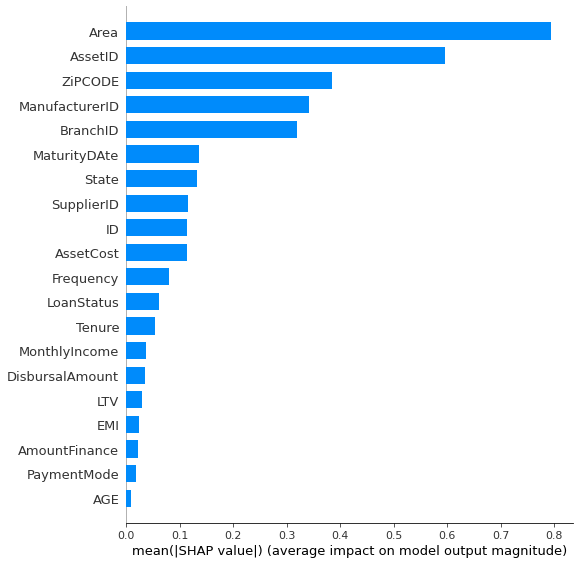

In [ ]:
plot_importances(model2, holdout_data, features)

### As we can see that AUC has not increased , And there are many features which we can remove from above image 

Now we will create a model3 with below ignored_features

In [ ]:
params3 = dict(params)
params3.update({"ignored_features": ['City', 
                                     'Area', 
                                     'AssetID', 
                                     'ZiPCODE', 
                                     'BranchID', 
                                     'ManufacturerID', 
                                     'State', 
                                     'ID', 
                                     'MaturityDAte',
                                     'SupplierID']})
model3 = CatBoostClassifier(**params3)
_ = model3.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

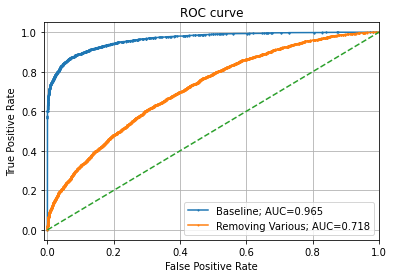

In [ ]:
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model3.predict_proba(holdout_data)[:,1]],
    ['Baseline', 'Removing Various']
)

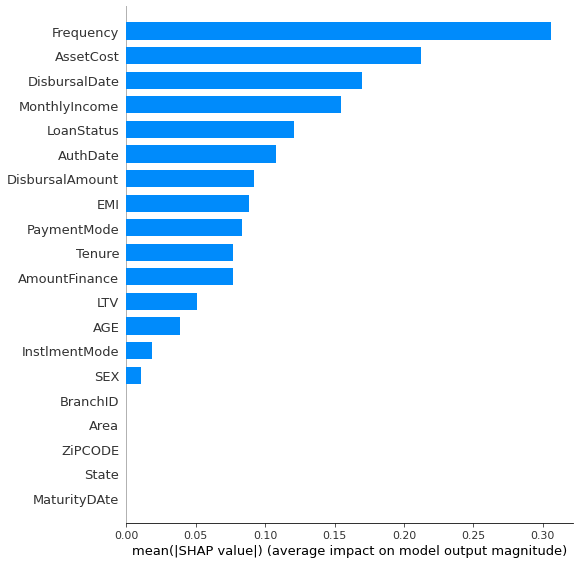

In [ ]:
plot_importances(model3, holdout_data, features)

Adversarial validation can help in identifying the not so obvious reasons why the model performed well on train data but terrible on the test data. Using this method, it is possible to develop very refined machine learning models for the real world which is why it is so popular among Kaggle competitors. As a drawback, this method is still developing and does not give solutions to fix data distribution problems yet. 


So now we will use Above Best Features from train_data for our final model 

### Part 3 : Final Part 

Important Variables to initialize

In [ ]:
obj_call_count = 0
cur_best_score = -np.inf
NB_CV_FOLDS = 3
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300
OOF_PREDICTION = True
NUM_OF_SPLITS = 5 # Used for OOF Prediction 
TRAIN_ON_FULL_DATA = True
hyperopt_params = []
MAX_EVALS = 10
FIND_BEST_HYPERPARAMETERS = False
TARGET_ENCODING = False

SEED = 2021

random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

##### Loading pre converted .xlsx file to | seperated file for faster loading of data

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/train_data.csv", sep='|')
train_bureau = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/train_bureau.csv", sep='|')
test_data = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/test_data.csv", sep='|')
test_bureau = pd.read_csv("/content/drive/MyDrive/LTFS_Top_up/Optimized_Solution/test_bureau.csv", sep='|')
sample_sub = test_data[['ID']].copy()
print("TRAIN",train_data.shape, train_bureau.shape)
print("TEST:",test_data.shape, test_bureau.shape)

TRAIN (128655, 26) (560844, 25)
TEST: (14745, 25) (64019, 25)


In [ ]:
display(train_data.head(2))
display(test_data.head(2))
print('\nBureau Data\n')
display(train_bureau.head(2))
display(test_bureau.head(2))

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID    Area  \
0   1   Monthly        Arrear     Closed       PDC_E         1     NaN   
1   2   Monthly       Advance     Closed         PDC       333  BHOPAL   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10  4022465            1568       21946  61.11   M   
1   2016-02-15  2012-03-31  4681175            1062       34802  70.00   M   

    AGE  MonthlyIncome    City           State   ZiPCODE       Top-up Month  
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0        > 48 Months  
1  23.0         666.67  SEHORE  MADHYA PRADESH  466001.0  No Top-up Service

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID  Area  Tenure  \
0   4   Monthly       Advance     Closed       PDC_E         2  GUNA      46   
1   5   Monthly       Advance     Closed         PDC         2  GUNA      45   

   AssetCost  AmountFinance  DisbursalAmount     EMI DisbursalDate  \
0     480000       365000.0         365000.0  1000.0    2011-12-29   
1     480000       285000.0         285000.0  9300.0    2012-04-28   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2015-10-05  2011-12-29  3524747          1046.0       22354  75.83   M   
1   2016-01-01  2012-04-28  4985862          1046.0       22354  57.44   M   

    AGE  MonthlyIncome  City           State   ZiPCODE  
0  50.0        32069.0  GUNA  MADHYA PRADESH  473001.0  
1  35.0        25000.0  GUNA  MADHYA PRADESH  473001.0


Bureau Data



ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT CLOSE-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05      NaN   
1    2019-12-31    Individual         Active   2018-03-19      NaN   

  LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT DISBURSED-AMT/HIGH CREDIT  \
0        2018-02-27                   NaN                    37,352   
1        2019-12-19                   NaN                    44,000   

  INSTALLMENT-AMT CURRENT-BAL INSTALLMENT-FREQUENCY OVERDUE-AMT  \
0             NaN      37,873                   NaN      37,873   
1   1,405/Monthly      20,797                   F03         NaN   

   WRITE-OFF-AMT ASSET_CLASS  \
0            0.0    Standard   
1            0.0    Standard   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   

                                          DPD - HIST  \
0                                             030000   
1  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                       37873,12820,   
1  20797,21988,23174,24341,25504,26648,27780,2891...   

           AMT OVERDUE - HIST         AMT PAID - HIST  TENURE  
0                     37873,,                      ,,     NaN  
1  ,,,,,,,,,,,,,,,,,,,,1452,,  ,,,,,,,,,,,,,,,,,,,,,,    36.0

ID  SELF-INDICATOR MATCH-TYPE     ACCT-TYPE CONTRIBUTOR-TYPE DATE-REPORTED  \
0   4           False    PRIMARY   Credit Card              CCC    2019-11-17   
1   4           False    PRIMARY  Housing Loan              HFC    2019-10-31   

  OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT CLOSE-DT LAST-PAYMENT-DATE  \
0    Individual         Active   2019-09-26      NaN               NaN   
1         Joint         Active   2017-06-21      NaN        2019-10-15   

  CREDIT-LIMIT/SANC AMT DISBURSED-AMT/HIGH CREDIT INSTALLMENT-AMT CURRENT-BAL  \
0                10,000                       588             NaN         589   
1                   NaN                 25,00,000  30,797/Monthly   21,07,227   

  INSTALLMENT-FREQUENCY OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN           0            0.0         NaN   
1                   F03           0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                          20191117,   
1  20191031,20190930,20190831,20190731,20190630,2...   

                                          DPD - HIST  \
0                                                000   
1  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                               589,   
1  2107227,2122196,2136877,2151448,2165910,218026...   

                                  AMT OVERDUE - HIST  \
0                                                 0,   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   

                 AMT PAID - HIST  TENURE  
0                             0,     NaN  
1  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,   120.0

In [ ]:
print(train_data.columns)
print(train_bureau.columns)

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
       'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
       'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month'],
      dtype='object')
Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
       'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
       'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
       'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'TENURE'],
      dtype='object')


Now we will check percentage value of Top up months all categories

In [ ]:
train_data['Top-up Month'].value_counts()/train_data.shape[0]

No Top-up Service    0.829171
 > 48 Months         0.065027
36-48 Months         0.028417
24-30 Months         0.027142
30-36 Months         0.023800
18-24 Months         0.018406
12-18 Months         0.008037
Name: Top-up Month, dtype: float64

### Re formatting Numerical Values 

Extracting Numerical values from features like 31,324 (has comma)

Installment-Amt has value like 1234/monthly. We will extract Numerical value from this 

In [ ]:
datacheck = "31,324"
str(datacheck).split(',')

['31', '324']

Join method helps to create a string from iterable objects

In [ ]:
''.join(str(datacheck).split(','))

'31324'

In [ ]:
def fetch_numeric_value(data):
    return np.nan if str(data).lower() == 'nan' else int(''.join(str(data).split(',')))

In [ ]:
train_bureau['CREDIT-LIMIT/SANC AMT'] = train_bureau['CREDIT-LIMIT/SANC AMT'].apply(fetch_numeric_value)    
test_bureau['CREDIT-LIMIT/SANC AMT'] = test_bureau['CREDIT-LIMIT/SANC AMT'].apply(fetch_numeric_value)

train_bureau['DISBURSED-AMT/HIGH CREDIT'] = train_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(fetch_numeric_value)
test_bureau['DISBURSED-AMT/HIGH CREDIT'] = test_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(fetch_numeric_value)

#First We will split at / and take 0 th value and then use fetch_numeric_value() Eg: 31,324/Monthly -- 31,324 -- 31324

tmp = train_bureau['INSTALLMENT-AMT'].copy()
train_bureau['INSTALLMENT-AMT'] = tmp.apply(lambda x: np.nan if str(x).lower() == 'nan' else x.split('/')[0])
train_bureau['INSTALLMENT-AMT'] = train_bureau['INSTALLMENT-AMT'].apply(fetch_numeric_value)
train_bureau['CURRENT-BAL'] = train_bureau['CURRENT-BAL'].apply(fetch_numeric_value)    
train_bureau['OVERDUE-AMT'] = train_bureau['OVERDUE-AMT'].apply(fetch_numeric_value)    

tmp = test_bureau['INSTALLMENT-AMT'].copy()
test_bureau['INSTALLMENT-AMT'] = tmp.apply(lambda x: np.nan if str(x).lower() == 'nan' else x.split('/')[0])
test_bureau['INSTALLMENT-AMT'] = test_bureau['INSTALLMENT-AMT'].apply(fetch_numeric_value)
test_bureau['CURRENT-BAL'] = test_bureau['CURRENT-BAL'].apply(fetch_numeric_value)    
test_bureau['OVERDUE-AMT'] = test_bureau['OVERDUE-AMT'].apply(fetch_numeric_value)   

#Fix ASSET_CLASS categories
#['Standard', nan, 'Special Mention Account', 'SubStandard','Doubtful', 'Loss', '1', '01', '2']
#we can merge 1 with 01 and Replace all with these values with Standard
train_bureau.ASSET_CLASS = train_bureau.ASSET_CLASS.apply(lambda x: 'Standard' if x in ['1','01'] else x)
test_bureau.ASSET_CLASS = test_bureau.ASSET_CLASS.apply(lambda x: 'Standard' if x in ['1','01'] else x)

In [ ]:
train_bureau.head(2)

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT CLOSE-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05      NaN   
1    2019-12-31    Individual         Active   2018-03-19      NaN   

  LAST-PAYMENT-DATE  CREDIT-LIMIT/SANC AMT  DISBURSED-AMT/HIGH CREDIT  \
0        2018-02-27                    NaN                      37352   
1        2019-12-19                    NaN                      44000   

   INSTALLMENT-AMT  CURRENT-BAL INSTALLMENT-FREQUENCY  OVERDUE-AMT  \
0              NaN      37873.0                   NaN      37873.0   
1           1405.0      20797.0                   F03          NaN   

   WRITE-OFF-AMT ASSET_CLASS  \
0            0.0    Standard   
1            0.0    Standard   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   

                                          DPD - HIST  \
0                                             030000   
1  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                       37873,12820,   
1  20797,21988,23174,24341,25504,26648,27780,2891...   

           AMT OVERDUE - HIST         AMT PAID - HIST  TENURE  
0                     37873,,                      ,,     NaN  
1  ,,,,,,,,,,,,,,,,,,,,1452,,  ,,,,,,,,,,,,,,,,,,,,,,    36.0

### Impute Missing Values 

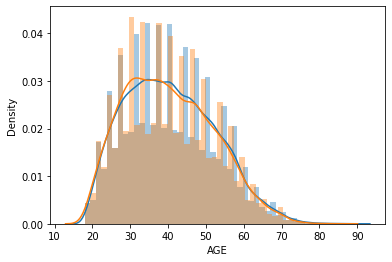

In [ ]:
sns.distplot(train_data['AGE'])
sns.distplot(test_data['AGE'])

age_most_freq = train_data['AGE'].mode()[0]
train_data['AGE'] = train_data['AGE'].fillna(age_most_freq)
test_data['AGE'] = test_data['AGE'].fillna(age_most_freq)

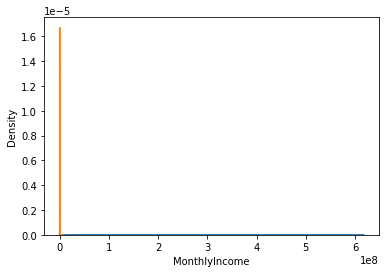

In [ ]:
sns.distplot(train_data['MonthlyIncome'])
sns.distplot(test_data['MonthlyIncome'])
income_median = train_data['MonthlyIncome'].median()
train_data['MonthlyIncome'] = train_data['MonthlyIncome'].fillna(income_median)
test_data['MonthlyIncome'] = test_data['MonthlyIncome'].fillna(income_median)

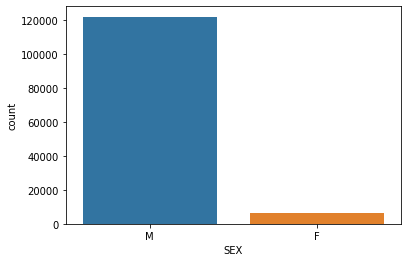

In [ ]:
sns.countplot(train_data.SEX)
sns.countplot(test_data.SEX)
sex_most_freq = train_data['SEX'].mode()[0]
train_data['SEX'] = train_data['SEX'].fillna(sex_most_freq)
test_data['SEX'] = test_data['SEX'].fillna(sex_most_freq)

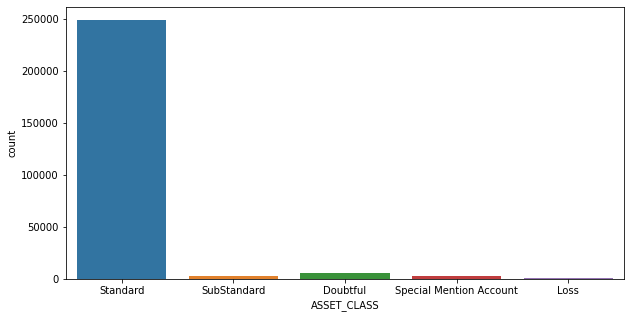

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(train_bureau.ASSET_CLASS)
sns.countplot(test_bureau.ASSET_CLASS)
asset_most_freq = train_bureau['ASSET_CLASS'].mode()[0]
train_bureau['ASSET_CLASS'] = train_bureau['ASSET_CLASS'].fillna(asset_most_freq)
test_bureau['ASSET_CLASS'] = test_bureau['ASSET_CLASS'].fillna(asset_most_freq)

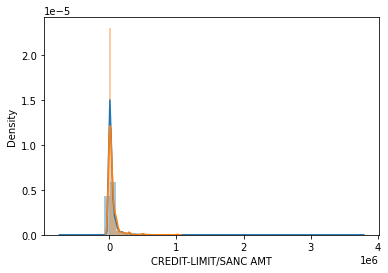

In [ ]:
sns.distplot(train_bureau['CREDIT-LIMIT/SANC AMT'])
sns.distplot(test_bureau['CREDIT-LIMIT/SANC AMT'])

train_bureau['CREDIT-LIMIT/SANC AMT'] = train_bureau['CREDIT-LIMIT/SANC AMT'].fillna(0.0)
test_bureau['CREDIT-LIMIT/SANC AMT'] = test_bureau['CREDIT-LIMIT/SANC AMT'].fillna(0.0)

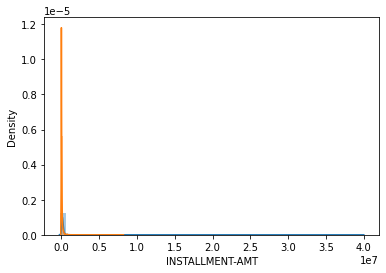

In [ ]:
sns.distplot(train_bureau['INSTALLMENT-AMT'])
sns.distplot(test_bureau['INSTALLMENT-AMT'])

train_bureau['INSTALLMENT-AMT'] = train_bureau['INSTALLMENT-AMT'].fillna(0.0)
test_bureau['INSTALLMENT-AMT'] = test_bureau['INSTALLMENT-AMT'].fillna(0.0)

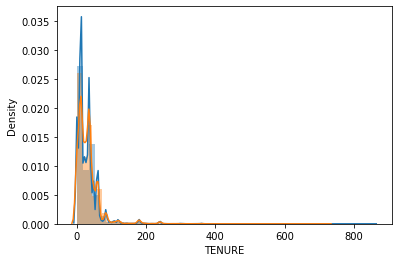

In [ ]:
sns.distplot(train_bureau['TENURE'])
sns.distplot(test_bureau['TENURE'])
tenure_median = train_bureau['TENURE'].median()
train_bureau['TENURE'] = train_bureau['TENURE'].fillna(tenure_median)
test_bureau['TENURE'] = test_bureau['TENURE'].fillna(tenure_median)

In [ ]:
train_data.shape , test_data.shape

((128655, 26), (14745, 25))

In [ ]:
all_data = pd.concat([train_data, test_data])
all_data = all_data.reset_index(drop=True)
print(all_data.shape)

(143400, 26)


In [ ]:
all_data.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  
0        > 48 Months  
1  No Top-up Service  
2       12-18 Months  
3        > 48 Months  
4       36-48 Months

# Feature Engineering:

> Extracting the whole values from the numerical features. Idea behind this is to avoid the minor differences and treating two values equally same

Example: 
        
        value1 = 100345 and value2 = 100045

        value1___whole_number = 100000 and value2___whole_number = 100000

In [ ]:
def make_whole_number(data):
    if str(data).lower() == 'nan':
        return np.nan
    else:
        _data = str(int(data))
        _len_data = len(_data)
        _data = "".join(_data[0] + '0' * (_len_data-1))
        return int(_data)

In [ ]:
a = make_whole_number('100345')
a

100000

In [ ]:
data = '1002435'
data[0]

'1'

In [ ]:
for fe in ['DisbursalAmount', 
            'MonthlyIncome', 
            'AGE', 
            'Tenure', 
            'EMI', 
            'AssetCost']:
    print("Fetching whole number:",fe)
    all_data[fe+"___WHOLE_NUMBER"] = all_data[fe].apply(make_whole_number)

Fetching whole number: DisbursalAmount
Fetching whole number: MonthlyIncome
Fetching whole number: AGE
Fetching whole number: Tenure
Fetching whole number: EMI
Fetching whole number: AssetCost


In [ ]:
all_data.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  
0               20000                    400000  
1               10000                    400000  
2               30000                    600000  
3               10000                    400000  
4               10000                    600000

In [ ]:
all_data.shape

(143400, 32)

Binning Numerical Features

Qcut - Quantile Based Discretization Function

This basically means that qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins.

Keep in mind the values for the 25%, 50% and 75% percentiles in describe() are using qcut


Why do we use Binning ?

Binning, also known as quantization is used for transforming continuous numeric features into discrete ones (categories). These discrete values or numbers can be thought of as categories or bins into which the raw, continuous numeric values are binned or grouped into.

In [ ]:
def create_bin_features(input_df, features):
    for bin_fe in features:
        print("Binning: ",bin_fe)
        input_df[bin_fe+"___BINS"] = pd.qcut(input_df[bin_fe], 10, labels=False, duplicates='drop')
    
    return input_df

In [ ]:
binning_num_features = ['DisbursalAmount', 
                        'MonthlyIncome', 
                        'AGE', 
                        'Tenure', 
                        'EMI', 
                        'LTV',
                        'AssetCost'
                        ]
all_data = create_bin_features(all_data, binning_num_features)

Binning:  DisbursalAmount
Binning:  MonthlyIncome
Binning:  AGE
Binning:  Tenure
Binning:  EMI
Binning:  LTV
Binning:  AssetCost


In [ ]:
all_data.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  
0                 0  
1                 1  
2                 9  
3                 1  
4                 7

In [ ]:
all_data['MonthlyIncome___BINS'].value_counts()

5    21820
0    15015
4    14886
8    14337
9    14336
7    14320
3    14206
2    14194
1    13954
6     6332
Name: MonthlyIncome___BINS, dtype: int64

### Outlier Treatment 

> * Tried clipping the lower and high values but didn't improve the cross-validation score.

> * Added an extra boolean feature which contains True if value is less than or higher than the IQR (Inter-quantile Range) else False

In [ ]:
def outlier_treatement(input_demo, features):
    
    for fe in features:
        
        #CLIPPING MonthlyIncome and finding outliers
        Q1 = input_demo[fe].quantile(.25)
        Q3 = input_demo[fe].quantile(.75)
        Q_10 = input_demo[fe].quantile(0.1)
        Q_90 = input_demo[fe].quantile(0.9)

        IQR = Q3-Q1

        low_lim = Q1 - (IQR*1.5)
        high_lim = Q3 + (IQR*1.5)
        print(Q_10, Q_90)
        input_demo[fe+"___OUTLIERS"] = input_demo[fe].apply(lambda x: x<low_lim and x>high_lim)
#         input_demo[fe] = input_demo[fe].clip(Q_10, Q_90)
    
    return input_demo

In [ ]:
all_data = outlier_treatement(all_data, ['MonthlyIncome', 'AGE', 'EMI', 'DisbursalAmount', 'AssetCost','LTV', 'Tenure'])
all_data.head()

16666.67 73750.0
26.0 57.0
14954.700000000004 87000.0
200000.0 480000.0
450000.0 670000.0
37.52 78.12
24.0 60.0


ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                 0                     False           False           False   
1                 1                     False           False           False   
2                 9                     False           False           False   
3                 1                     False           False           False   
4                 7                     False           False 

#### Splitting of Train Test -- One we complete All_Data Feature Engoneering

In [ ]:
_len_train_demo = len(train_data)
train_data = all_data[: _len_train_demo].copy()
test_data = all_data[_len_train_demo:].copy()
print(train_data.shape, test_data.shape)

(128655, 46) (14745, 46)


### ANNOVA TEST

An Analysis of Variance Test, or ANOVA, can be thought of as a generalization of the t-tests for more than 2 groups. The independent t-test is used to compare the means of a condition between two groups. ANOVA is used when we want to compare the means of a condition between more than two groups.

To perform any tests, we first need to define the null and alternate hypothesis:

Null Hypothesis – There is no significant difference among the groups
Alternate Hypothesis – There is a significant difference among the groups

In [ ]:
targets= train_data['Top-up Month'].unique()
for fe in ['DisbursalAmount','Tenure']:
    F, p = stats.f_oneway(
                          train_data[train_data['Top-up Month'] == targets[0]][fe],
                          train_data[train_data['Top-up Month'] == targets[1]][fe],
                          train_data[train_data['Top-up Month'] == targets[2]][fe],
                          train_data[train_data['Top-up Month'] == targets[3]][fe],
                          train_data[train_data['Top-up Month'] == targets[4]][fe],
                          train_data[train_data['Top-up Month'] == targets[5]][fe],
                          train_data[train_data['Top-up Month'] == targets[6]][fe],
                         )
    if p < 0.05:
        print('ANOVA: {} - {}:{}'.format(fe, F,p))

ANOVA: DisbursalAmount - 373.4898298560852:0.0
ANOVA: Tenure - 117.06733859263751:4.760210576690185e-148


We see that p-value <0.05.  
Hence, we can reject the Null Hypothesis – there are no differences among different Top-Up-Months groups.

In [ ]:
train_data.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                 0                     False           False           False   
1                 1                     False           False           False   
2                 9                     False           False           False   
3                 1                     False           False           False   
4                 7                     False           False 

In [ ]:
targets= train_data['Top-up Month'].unique()
for fe in ['AssetCost','AmountFinance','MonthlyIncome','EMI']:
    F, p = stats.f_oneway(
                          train_data[train_data['Top-up Month'] == targets[0]][fe],
                          train_data[train_data['Top-up Month'] == targets[1]][fe],
                          train_data[train_data['Top-up Month'] == targets[2]][fe],
                          train_data[train_data['Top-up Month'] == targets[3]][fe],
                          train_data[train_data['Top-up Month'] == targets[4]][fe],
                          train_data[train_data['Top-up Month'] == targets[5]][fe],
                          train_data[train_data['Top-up Month'] == targets[6]][fe],
                         )
    if p < 0.05:
        print('ANOVA: {} - {}:{}'.format(fe, F,p))

ANOVA: AssetCost - 154.34408321204722:4.506382982691637e-196
ANOVA: AmountFinance - 372.8524068588624:0.0
ANOVA: EMI - 46.31451980819717:5.14873686284115e-57


We see that p-value <0.05.
Hence, we can reject the Null Hypothesis – there are no differences among different Top-Up-Months groups.

In [ ]:
train_data.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                 0                     False           False           False   
1                 1                     False           False           False   
2                 9                     False           False           False   
3                 1                     False           False           False   
4                 7                     False           False 

In [ ]:
bureau_dup_mask = train_bureau.duplicated()

# merge_demographic_bureau_data:

> This function is the heart of feature engineering pipeline.

    > From categorical features added CountVectorizer like features

    > From numerical features created various aggregrated features

In [ ]:
input_demo_arg = train_data.copy()
input_bureau_arg = train_bureau[~bureau_dup_mask]

In [ ]:
input_demo_arg.shape , input_bureau_arg.shape

((128655, 46), (556978, 25))

In [ ]:
input_demo = input_demo_arg.copy()
input_bureau = input_bureau_arg.copy()
print(input_demo.shape, input_bureau.shape)

(128655, 46) (556978, 25)


### Helper Functions

In [ ]:
def extract_past_dues(data):
    if 'E' in data:
        data = "{}".format(int(float(data)))
    data = data.replace('D', '0')
    data = data.replace('X', '0')
    tokens = [int(data[i:i+3]) for i in range(0,len(data),3)]
    #print(tokens)
    return tokens ## Will return List of Tokens which are splitted at every 3rd digit

def extract_past_payments(data):
    tokens = [ 0 if len(_)==0 else float(_) for _ in data.split(',')]
    return tokens ## Will return list of strings which are splitted by using ','


def extract_past_dues_12_months(data):
    past_dues_tokens = extract_past_dues(data)[:12]
    return past_dues_tokens #Will return first 12 elements from list which is returned by extract_past_dues

def extract_past_dues_24_months(data):
    past_dues_tokens = extract_past_dues(data)[:24]
    return past_dues_tokens #Will return first 24 elements from list which is returned by extract_past_dues

def extract_past_payments_12_months(data):
    tokens = extract_past_payments(data)[:12]
    return tokens #Will return first 12 elements from list which is returned by extract_past_payments

def extract_past_payments_24_months(data):
    tokens = extract_past_payments(data)[:24]
    return tokens #Will return first 24 elements from list which is returned by extract_past_payments


#Will return Average values of dues and payments for 12,24 months

def average_dues_12_months(data):
    past_dues_tokens = extract_past_dues_12_months(data)
    return sum(past_dues_tokens)/12 

def average_dues_24_months(data):
    past_dues_tokens = extract_past_dues_24_months(data)
    return sum(past_dues_tokens)/24

def average_past_payments_12_months(data):
    past_dues_tokens = extract_past_payments_12_months(data)
    return sum(past_dues_tokens)/12

def average_past_payments_24_months(data):
    past_dues_tokens = extract_past_payments_24_months(data)
    return sum(past_dues_tokens)/24

In [ ]:
extract_past_payments(',,,100,200')

[0, 0, 0, 100.0, 200.0]

In [ ]:
extract_past_payments(',,')

[0, 0, 0]

In [ ]:
extract_past_dues('000000DDD054024024000000000000000000')

[0, 0, 0, 54, 24, 24, 0, 0, 0, 0, 0, 0]

In [ ]:
average_dues_24_months('000000DDD054024024000000000000000000')

4.25

In [ ]:
def check_due_past_payment(data):
    for _ in ['1','2','3','4','5','6','7','8','9']:
        if _ in data:
            return True
    return False    
    
def fetch_amount(data):
    raw_token = data.split(',')
    token = []
    for _ in raw_token:
        if len(_) == 0:
            token.append(0)
        else:
            token.append(float(_))
    return sum(token)

def month_bucket(month):
    if month < 12:
        return  'LESS_THAN_12_BUCKET'
    elif month >= 12 and month < 18:
        return '12_18_BUCKET'
    elif month >= 18 and month < 24:
        return '18_24_BUCKET'
    elif month >= 24 and month < 30:
        return '24_30_BUCKET'
    elif month >= 30 and month < 36:
        return '30_36_BUCKET'
    elif month >= 36 and month < 48:
        return '36_48_BUCKET'
    elif month >= 48:
        return '>48_BUCKET'

In [ ]:
print(input_demo.shape, input_bureau.shape)

(128655, 46) (556978, 25)


In [ ]:
## Since PDC and PDC_E were same we removed _E and made PDC_E to PDC
input_demo.PaymentMode = input_demo.PaymentMode.apply(lambda x: x.split('_')[0])

#### Creating New Features 

In [ ]:
input_demo['AGE_WHEN_LOAN_COMPLETES'] = input_demo['AGE'] + input_demo['Tenure']//12
input_demo['EMI_INCOME_RATO'] = input_demo.EMI / input_demo.MonthlyIncome
input_demo.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed           PDC         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                 0                     False           False           False   
1                 1                     False           False           False   
2                 9                     False           False           False   
3                 1                     False           False           False   
4                 7                     False           False 

In [ ]:
## Disbursal Date in Train data and Bureau data is converted to_datetime
input_demo['DisbursalDate'] = pd.to_datetime(input_demo['DisbursalDate'])
input_bureau['DISBURSED-DT'] = pd.to_datetime(input_bureau['DISBURSED-DT'])
input_demo.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed           PDC         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte    AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10   4022465          1568.0       21946  61.11   M   
1   2016-02-15  2012-03-31   4681175          1062.0       34802  70.00   M   
2   2023-02-10  2017-06-17  25328146          1060.0      127335  69.77   M   
3   2017-11-10  2013-11-29  13021591          1060.0       25094  80.92   M   
4   2015-07-05  2011-12-08   3291320          1046.0       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
0        > 48 Months                          200000   
1  No Top-up Service                          300000   
2       12-18 Months                          500000   
3        > 48 Months                          400000   
4       36-48 Months                          400000   

   MonthlyIncome___WHOLE_NUMBER  AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  \
0                         30000                  40                     40   
1                           600                  20                     40   
2                         40000                  30                     60   
3                         20000                  20                     40   
4                         20000                  50                     40   

   EMI___WHOLE_NUMBER  AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  \
0               20000                    400000                       2   
1               10000                    400000                       4   
2               30000                    600000                       9   
3               10000                    400000                       6   
4               10000                    600000                       7   

   MonthlyIncome___BINS  AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  \
0                     4           7              4           1           5   
1                     0           0              3           0           7   
2                     6           4              6           3           7   
3                     1           0              4           0           9   
4                     3           8              3           1           7   

   AssetCost___BINS  MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                 0                     False           False           False   
1                 1                     False           False           False   
2                 9                     False           False           False   
3                 1                     False           False           False   
4                 7                     False           False 

In [ ]:
## Use only that values which are not null
input_bureau = input_bureau[~input_bureau['DISBURSED-AMT/HIGH CREDIT'].isnull()]

input_bureau['DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER'] = input_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(make_whole_number)
input_bureau['CURRENT-BAL___WHOLE_NUMBER'] = input_bureau['CURRENT-BAL'].apply(make_whole_number)    
input_bureau['OVERDUE-AMT___WHOLE_NUMBER'] = input_bureau['OVERDUE-AMT'].apply(make_whole_number)    
input_bureau["WRITE-OFF-AMT___WHOLE_NUMBER"] = input_bureau["WRITE-OFF-AMT"].apply(make_whole_number)

In [ ]:
input_demo.shape , input_bureau.shape

((128655, 48), (556978, 29))

In [ ]:
input_demo.columns

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
       'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
       'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month',
       'DisbursalAmount___WHOLE_NUMBER', 'MonthlyIncome___WHOLE_NUMBER',
       'AGE___WHOLE_NUMBER', 'Tenure___WHOLE_NUMBER', 'EMI___WHOLE_NUMBER',
       'AssetCost___WHOLE_NUMBER', 'DisbursalAmount___BINS',
       'MonthlyIncome___BINS', 'AGE___BINS', 'Tenure___BINS', 'EMI___BINS',
       'LTV___BINS', 'AssetCost___BINS', 'MonthlyIncome___OUTLIERS',
       'AGE___OUTLIERS', 'EMI___OUTLIERS', 'DisbursalAmount___OUTLIERS',
       'AssetCost___OUTLIERS', 'LTV___OUTLIERS', 'Tenure___OUTLIERS',
       'AGE_WHEN_LOAN_COMPLETES', 'EMI_INCOME_RATO'],
      dtype='object')

In [ ]:
input_bureau.columns

Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
       'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
       'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
       'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'TENURE',
       'DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER',
       'CURRENT-BAL___WHOLE_NUMBER', 'OVERDUE-AMT___WHOLE_NUMBER',
       'WRITE-OFF-AMT___WHOLE_NUMBER'],
      dtype='object')

In [ ]:
df_merged = pd.merge(input_demo, input_bureau)
df_merged.head()

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID Area  Tenure  \
0   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
1   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
2   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
3   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
4   1   Monthly        Arrear     Closed         PDC         1  NaN      48   

   AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0     450000       275000.0         275000.0  24000.0    2012-02-10   
1     450000       275000.0         275000.0  24000.0    2012-02-10   
2     450000       275000.0         275000.0  24000.0    2012-02-10   
3     450000       275000.0         275000.0  24000.0    2012-02-10   
4     450000       275000.0         275000.0  24000.0    2012-02-10   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
1   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
2   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
3   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
4   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   

    AGE  MonthlyIncome    City           State   ZiPCODE  Top-up Month  \
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
1  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
2  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
3  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
4  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   

   DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
0                          200000                         30000   
1                          200000                         30000   
2                          200000                         30000   
3                          200000                         30000   
4                          200000                         30000   

   AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
0                  40                     40               20000   
1                  40                     40               20000   
2                  40                     40               20000   
3                  40                     40               20000   
4                  40                     40               20000   

   AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
0                    400000                       2                     4   
1                    400000                       2                     4   
2                    400000                       2                     4   
3                    400000                       2                     4   
4                    400000                       2                     4   

   AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
0           7              4           1           5                 0   
1           7              4           1           5                 0   
2           7              4           1           5                 0   
3           7              4           1           5                 0   
4           7              4           1           5                 0   

   MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                     False           False           False   
1                     False           False           False   
2                     False           False           False   
3                     False           False           False   
4                     False           False           False   

   DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
0                

In [ ]:
df_merged.shape

(556978, 76)

Now we will Replace Null values in DisbursedDT with DisbursalDate value whenever DisbursedDt is null & ther is equal amount of Disbursal and Disbursed Amt/high credit and Self Indicator = True

In [ ]:
df_merged['DisbursalAmount'] == df_merged['DISBURSED-AMT/HIGH CREDIT']

0         False
1         False
2         False
3         False
4          True
          ...  
556973    False
556974    False
556975    False
556976    False
556977    False
Length: 556978, dtype: bool

In [ ]:
disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()
equal_amount = df_merged['DisbursalAmount'] == df_merged['DISBURSED-AMT/HIGH CREDIT']

## Check if all values are True -- If IT IS then we will use it further 
tmp_mask = disbursed_dt_isnull_mask & equal_amount & df_merged['SELF-INDICATOR'] 
tmp_mask

0         False
1         False
2         False
3         False
4         False
          ...  
556973    False
556974    False
556975    False
556976    False
556977    False
Length: 556978, dtype: bool

In [ ]:
df_merged[tmp_mask]  ### This will give me True values whole row that we got from above

ID    Frequency InstlmentMode LoanStatus   PaymentMode  BranchID  \
1079       154      Monthly       Advance     Closed           PDC         9   
1088       156      Monthly       Advance     Closed           PDC         9   
1151       172      Monthly       Advance     Closed        Billed         9   
1221       185      Monthly       Advance     Closed           PDC         9   
1245       192      Monthly       Advance     Closed           PDC         9   
...        ...          ...           ...        ...           ...       ...   
556806  143307      Quatrly        Arrear     Active  Direct Debit       270   
556836  143318      Quatrly        Arrear     Active  Direct Debit       270   
556840  143322      Monthly        Arrear     Closed           ECS       380   
556864  143341  Half Yearly        Arrear     Active           ECS       390   
556886  143353      Monthly        Arrear     Closed           ECS       397   

            Area  Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI  \
1079     BURDWAN      35     479410       200000.0         200000.0   7190.0   
1088     BURDWAN      15     465119       200000.0         200000.0  13500.0   
1151     BURDWAN      12     497832       200000.0         200000.0  18040.0   
1221     BURDWAN      12     510379       200000.0         200000.0  18035.0   
1245     BURDWAN      24     422075       200000.0         200000.0   9800.0   
...          ...     ...        ...            ...              ...      ...   
556806     PATNA      36     418000       320000.0         320000.0  34300.0   
556836     PATNA      36     580000       320000.0         320000.0  34100.0   
556840   SAHARSA      24     610000       376000.0         376000.0  18550.0   
556864    RATLAM      36     570000       329768.0         329768.0  70500.0   
556886  FAIZABAD      24     400000       250915.0         250915.0  12580.0   

       DisbursalDate MaturityDAte    AuthDate   AssetID  ManufacturerID  \
1079      2010-03-30   2013-02-05  2010-03-30    474180          1568.0   
1088      2010-03-30   2011-06-05  2010-03-30    474755          1046.0   
1151      2010-05-31   2011-05-05  2010-05-31    507710          1019.0   
1221      2010-07-31   2011-07-05  2010-07-31    552601          1046.0   
1245      2010-09-30   2012-09-05  2010-09-30    647577          1046.0   
...              ...          ...         ...       ...             ...   
556806    2018-02-09   2021-02-10  2018-02-09  28388816          1568.0   
556836    2018-06-08   2021-06-05  2018-06-08  29937015          1568.0   
556840    2018-10-10   2020-10-05  2018-10-11  31546455          1568.0   
556864    2018-07-06   2021-06-01  2018-07-07  30304324          1568.0   
556886    2018-12-11   2020-12-05  2018-12-11  32390447          1568.0   

        SupplierID    LTV SEX   AGE  MonthlyIncome    City           State  \
1079         24089  40.22   M  30.0       35833.33     NaN     WEST BENGAL   
1088         24390  40.10   M  34.0       25000.00     NaN     WEST BENGAL   
1151         22934  36.55   M  55.0       10000.00     NaN     WEST BENGAL   
1221         31318  35.65   M  27.0       15000.00     NaN     WEST BENGAL   
1245         31318  45.06   M  22.0       12000.00     NaN     WEST BENGAL   
...            ...    ...  ..   ...            ...     ...             ...   
556806       37905  76.56   M  41.0       38816.67  ARARIA           BIHAR   
556836       37905  49.29   M  61.0       35833.33  ARARIA           BIHAR   
556840      133478  61.64   M  34.0       48333.33  SUPAUL           BIHAR   
556864       26625  57.85   M  52.0       26250.00  RATLAM  MADHYA PRADESH   
556886      138128  62.73   M  42.0       50000.00   GONDA   UTTAR PRADESH   

         ZiPCODE       Top-up Month  DisbursalAmount___WHOLE_NUMBER  \
1079    713338.0        > 48 Months                          200000   
1088    722102.0  No Top-up Service                          200000   
1151    713212.0  No Top-up Service    

### For all above values in dataframe -- Copy DisbursalDate value in DisbursedDT

In [ ]:
df_merged[tmp_mask]['DISBURSED-DT'] = df_merged[ tmp_mask ]['DisbursalDate']

#### DISBURSED-DT is not null

In [ ]:
#Filter where 'DISBURSED-DT' is not null
disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()
df_merged = df_merged[~disbursed_dt_isnull_mask]
df_merged.shape

(525094, 76)

#### Now we will use only that rows where DisbursedAmt/High Credit  <= Disbursal Amont

i-e We will check values of other features where Disbursal Amount i-e Amount given as loan w.r.t  DisbursedAmt/High Credit in bureau.Only that value is taken where loan value of existing is less than current loan value requested

In [ ]:
df_merged =  df_merged[df_merged['DISBURSED-AMT/HIGH CREDIT'] <= df_merged['DisbursalAmount']]
df_merged.shape

(434466, 76)

In [ ]:
df_merged['DPD - HIST'] = df_merged['DPD - HIST'].fillna('000')
df_merged['ANY_PAST_DUE_DAYS'] = df_merged['DPD - HIST'].astype('str').apply(check_due_past_payment)
df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_12_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_12_months)    
df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_24_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_24_months)

In [ ]:
#AMT PAID - HIST
df_merged['AMT PAID - HIST'] = df_merged['AMT PAID - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_12_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_24_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_24_months)
df_merged['AMT_PAID_HIST_TOTAL'] = df_merged['AMT PAID - HIST'].apply(fetch_amount)

#AMT OVERDUE - HIST
df_merged['AMT OVERDUE - HIST'] = df_merged['AMT OVERDUE - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_12_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_24_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_24_months)
df_merged['AMT_OVERDUE_HIST_TOTAL'] = df_merged['AMT OVERDUE - HIST'].apply(fetch_amount)    

#CUR BAL - HIST
df_merged['CUR BAL - HIST'] = df_merged['CUR BAL - HIST'].fillna(',,,')
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_12_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_24_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_24_months)
df_merged['CUR_BAL_HIST_TOTAL'] = df_merged['CUR BAL - HIST'].apply(fetch_amount)

In [ ]:
df_merged.head()

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID Area  Tenure  \
0   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
1   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
2   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
4   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
5   1   Monthly        Arrear     Closed         PDC         1  NaN      48   

   AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0     450000       275000.0         275000.0  24000.0    2012-02-10   
1     450000       275000.0         275000.0  24000.0    2012-02-10   
2     450000       275000.0         275000.0  24000.0    2012-02-10   
4     450000       275000.0         275000.0  24000.0    2012-02-10   
5     450000       275000.0         275000.0  24000.0    2012-02-10   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
1   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
2   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
4   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
5   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   

    AGE  MonthlyIncome    City           State   ZiPCODE  Top-up Month  \
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
1  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
2  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
4  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
5  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   

   DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
0                          200000                         30000   
1                          200000                         30000   
2                          200000                         30000   
4                          200000                         30000   
5                          200000                         30000   

   AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
0                  40                     40               20000   
1                  40                     40               20000   
2                  40                     40               20000   
4                  40                     40               20000   
5                  40                     40               20000   

   AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
0                    400000                       2                     4   
1                    400000                       2                     4   
2                    400000                       2                     4   
4                    400000                       2                     4   
5                    400000                       2                     4   

   AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
0           7              4           1           5                 0   
1           7              4           1           5                 0   
2           7              4           1           5                 0   
4           7              4           1           5                 0   
5           7              4           1           5                 0   

   MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                     False           False           False   
1                     False           False           False   
2                     False           False           False   
4                     False           False           False   
5                     False           False           False   

   DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
0                

In [ ]:
df_merged['NEXT_LOAN_IN_MONTHS'] = (df_merged['DISBURSED-DT'] - df_merged['DisbursalDate']).apply(lambda x: x/np.timedelta64(1, 'M')).astype('int')
df_merged['NEXT_LOAN_BUCKET'] = df_merged['NEXT_LOAN_IN_MONTHS'].apply(month_bucket)
df_merged['OLD_NEW_LOAN_RATIO'] =  df_merged['DISBURSED-AMT/HIGH CREDIT'] / df_merged['DisbursalAmount']
df_merged.head()

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID Area  Tenure  \
0   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
1   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
2   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
4   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
5   1   Monthly        Arrear     Closed         PDC         1  NaN      48   

   AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0     450000       275000.0         275000.0  24000.0    2012-02-10   
1     450000       275000.0         275000.0  24000.0    2012-02-10   
2     450000       275000.0         275000.0  24000.0    2012-02-10   
4     450000       275000.0         275000.0  24000.0    2012-02-10   
5     450000       275000.0         275000.0  24000.0    2012-02-10   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
1   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
2   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
4   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
5   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   

    AGE  MonthlyIncome    City           State   ZiPCODE  Top-up Month  \
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
1  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
2  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
4  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
5  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   

   DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
0                          200000                         30000   
1                          200000                         30000   
2                          200000                         30000   
4                          200000                         30000   
5                          200000                         30000   

   AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
0                  40                     40               20000   
1                  40                     40               20000   
2                  40                     40               20000   
4                  40                     40               20000   
5                  40                     40               20000   

   AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
0                    400000                       2                     4   
1                    400000                       2                     4   
2                    400000                       2                     4   
4                    400000                       2                     4   
5                    400000                       2                     4   

   AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
0           7              4           1           5                 0   
1           7              4           1           5                 0   
2           7              4           1           5                 0   
4           7              4           1           5                 0   
5           7              4           1           5                 0   

   MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                     False           False           False   
1                     False           False           False   
2                     False           False           False   
4                     False           False           False   
5                     False           False           False   

   DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
0                

In [ ]:
df_merged.shape

(434466, 85)

In [ ]:
df_merged['NEXT_LOAN_IN_MONTHS'].value_counts()

 0       134604
 20        3178
 11        3177
 25        3123
 27        3122
          ...  
-1370         1
-346          1
-1374         1
-222          1
-257          1
Name: NEXT_LOAN_IN_MONTHS, Length: 413, dtype: int64

### Now we will take only that rows where Next_Loan_Months>=0


We will remove whole row if value is negative in Next Loan in Months

In [ ]:
other_existing_loan_from_ltfs = (df_merged['NEXT_LOAN_IN_MONTHS'].apply(lambda x: x>=0))
df_merged = df_merged[other_existing_loan_from_ltfs]
df_merged.shape

(323516, 85)

#### Preprocessing and Features Extraction using Group By ID

In [ ]:
cat_features = [
  'MATCH-TYPE', 
  'ACCT-TYPE', 
  'CONTRIBUTOR-TYPE', 
  'OWNERSHIP-IND', 
  'ACCOUNT-STATUS', 
  'ASSET_CLASS',
  'NEXT_LOAN_BUCKET', 
  'SELF-INDICATOR'
]

for cat_fe in cat_features:
  print(cat_fe)
  categories = [ cat_fe+"___"+_+"___COUNT" for _ in df_merged[cat_fe].dropna().astype('str').unique()]
  df_merged[categories] = 0
  cat_fe_count_dict = { _:{} for _ in categories}
  for _key, _grp in df_merged.groupby(['ID']):
      tmp = Counter(_grp[cat_fe].dropna().astype('str'))
      for k,v in tmp.items():
          prev_counts = cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"]
          prev_counts[str(_key)] = v
          cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"] = prev_counts
  for new_fe in categories:
      print(new_fe)
      id_to_count_mapping = cat_fe_count_dict[new_fe] 
      df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)


MATCH-TYPE
MATCH-TYPE___PRIMARY___COUNT
MATCH-TYPE___SECONDARY___COUNT
ACCT-TYPE
ACCT-TYPE___Overdraft___COUNT
ACCT-TYPE___Auto Loan (Personal)___COUNT
ACCT-TYPE___Tractor Loan___COUNT
ACCT-TYPE___Credit Card___COUNT
ACCT-TYPE___Commercial Vehicle Loan___COUNT
ACCT-TYPE___Gold Loan___COUNT
ACCT-TYPE___Consumer Loan___COUNT
ACCT-TYPE___Property Loan___COUNT
ACCT-TYPE___Personal Loan___COUNT
ACCT-TYPE___Two-Wheeler Loan___COUNT
ACCT-TYPE___Business Loan General___COUNT
ACCT-TYPE___Business Loan Priority Sector  Agriculture___COUNT
ACCT-TYPE___Kisan Credit Card___COUNT
ACCT-TYPE___Corporate Credit Card___COUNT
ACCT-TYPE___Business Non-Funded Credit Facility-Priority Sector-Agriculture___COUNT
ACCT-TYPE___Other___COUNT
ACCT-TYPE___Housing Loan___COUNT
ACCT-TYPE___Loan Against Shares / Securities___COUNT
ACCT-TYPE___Loan Against Bank Deposits___COUNT
ACCT-TYPE___Used Car Loan___COUNT
ACCT-TYPE___Loan to Professional___COUNT
ACCT-TYPE___Business Loan Priority Sector  Others___COUNT
ACCT-TYPE

In [ ]:
df_merged.head()

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID Area  Tenure  \
0   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
1   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
2   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
4   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
5   1   Monthly        Arrear     Closed         PDC         1  NaN      48   

   AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0     450000       275000.0         275000.0  24000.0    2012-02-10   
1     450000       275000.0         275000.0  24000.0    2012-02-10   
2     450000       275000.0         275000.0  24000.0    2012-02-10   
4     450000       275000.0         275000.0  24000.0    2012-02-10   
5     450000       275000.0         275000.0  24000.0    2012-02-10   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
1   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
2   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
4   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
5   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   

    AGE  MonthlyIncome    City           State   ZiPCODE  Top-up Month  \
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
1  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
2  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
4  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
5  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   

   DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
0                          200000                         30000   
1                          200000                         30000   
2                          200000                         30000   
4                          200000                         30000   
5                          200000                         30000   

   AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
0                  40                     40               20000   
1                  40                     40               20000   
2                  40                     40               20000   
4                  40                     40               20000   
5                  40                     40               20000   

   AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
0                    400000                       2                     4   
1                    400000                       2                     4   
2                    400000                       2                     4   
4                    400000                       2                     4   
5                    400000                       2                     4   

   AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
0           7              4           1           5                 0   
1           7              4           1           5                 0   
2           7              4           1           5                 0   
4           7              4           1           5                 0   
5           7              4           1           5                 0   

   MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
0                     False           False           False   
1                     False           False           False   
2                     False           False           False   
4                     False           False           False   
5                     False           False           False   

   DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
0                

### Preprocessing and Features Extraction using GroupBY ID

In [ ]:
numerical_features = [
    "CREDIT-LIMIT/SANC AMT", 
    "DISBURSED-AMT/HIGH CREDIT",
    "INSTALLMENT-AMT", 
    "CURRENT-BAL",
    "OVERDUE-AMT",
    "WRITE-OFF-AMT",        
    "AMT_PAID_HIST_TOTAL",
    "AMT_OVERDUE_HIST_TOTAL",
    "CUR_BAL_HIST_TOTAL",
    "OLD_NEW_LOAN_RATIO",
    "DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER",
    "CURRENT-BAL___WHOLE_NUMBER",
    "OVERDUE-AMT___WHOLE_NUMBER",
    "WRITE-OFF-AMT___WHOLE_NUMBER",
#         "TENURE",
]


agg_col_sep = '____'
agg_for_customer = {}
for _agg_col in numerical_features:
    print(_agg_col,'MEAN_PER_CUSTOMER')
    tmp_dict = {}            
    for _key, _grp in df_merged.groupby(['ID']):
        _mean = _grp[_agg_col].mean()
        _str_key = str(_key)
        tmp_dict[_str_key] = _mean
    agg_for_customer[_agg_col+agg_col_sep+"MEAN_PER_CUSTOMER"] = tmp_dict
    
for agg_keys, agg_values in agg_for_customer.items():
    df_merged[agg_keys] = 0
    filtered_df = df_merged
    fetch_agg_values = filtered_df.ID.astype('str').apply(lambda x: agg_values[x] if x in agg_values else 0.0)
    df_merged.loc[filtered_df.index, agg_keys] = fetch_agg_values

    
loan_buckets = df_merged['NEXT_LOAN_BUCKET'].unique()
for num_fe in numerical_features:
    print(num_fe)
    categories = [ num_fe+"___"+_+"___MEAN" for _ in loan_buckets]
    df_merged[categories] = 0
    num_fe_avg_dict = { _:{} for _ in categories}
    for (_id,_loan_bucket), _grp in df_merged.groupby(['ID','NEXT_LOAN_BUCKET']):
        col_mean = _grp[num_fe].mean()
        prev_counts = num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"]
        prev_counts[str(_id)] = col_mean
        num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"] = prev_counts

    for new_fe in categories:
        print(new_fe)
        id_to_count_mapping = num_fe_avg_dict[new_fe] 
        df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)

train_id_counts = Counter(df_merged.ID)
ctr = 0
single_record_ids = []
multi_record_ids = []
for k,v in train_id_counts.items():
    if v>1:
        ctr += 1
        multi_record_ids.append(k)
    else:
        single_record_ids.append(k)

print("#of IDs have more than 1 records: {} out of {} these IDs".format(ctr, len(train_id_counts)))
df_merged = df_merged[df_merged.ID.isin(multi_record_ids)]

df_merged = df_merged.sort_values(by=['ID','SELF-INDICATOR','NEXT_LOAN_IN_MONTHS'], ascending=[True, False, False])
#     df_merged = df_merged[(df_merged['NEXT_LOAN_IN_MONTHS'] == 0) & (df_merged['OLD_NEW_LOAN_RATIO'] == 1.0) & (df_merged['SELF-INDICATOR'] == True)]

print("Returning DF.SHAPE:",df_merged.shape)

CREDIT-LIMIT/SANC AMT MEAN_PER_CUSTOMER
DISBURSED-AMT/HIGH CREDIT MEAN_PER_CUSTOMER
INSTALLMENT-AMT MEAN_PER_CUSTOMER
CURRENT-BAL MEAN_PER_CUSTOMER
OVERDUE-AMT MEAN_PER_CUSTOMER
WRITE-OFF-AMT MEAN_PER_CUSTOMER
AMT_PAID_HIST_TOTAL MEAN_PER_CUSTOMER
AMT_OVERDUE_HIST_TOTAL MEAN_PER_CUSTOMER
CUR_BAL_HIST_TOTAL MEAN_PER_CUSTOMER
OLD_NEW_LOAN_RATIO MEAN_PER_CUSTOMER
DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER MEAN_PER_CUSTOMER
CURRENT-BAL___WHOLE_NUMBER MEAN_PER_CUSTOMER
OVERDUE-AMT___WHOLE_NUMBER MEAN_PER_CUSTOMER
WRITE-OFF-AMT___WHOLE_NUMBER MEAN_PER_CUSTOMER
CREDIT-LIMIT/SANC AMT
CREDIT-LIMIT/SANC AMT___36_48_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___>48_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___LESS_THAN_12_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___18_24_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___24_30_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___12_18_BUCKET___MEAN
CREDIT-LIMIT/SANC AMT___30_36_BUCKET___MEAN
DISBURSED-AMT/HIGH CREDIT
DISBURSED-AMT/HIGH CREDIT___36_48_BUCKET___MEAN
DISBURSED-AMT/HIGH CREDIT___>48_

In [ ]:
df_merged.head()

ID Frequency InstlmentMode LoanStatus PaymentMode  BranchID Area  Tenure  \
2   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
4   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
1   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
5   1   Monthly        Arrear     Closed         PDC         1  NaN      48   
0   1   Monthly        Arrear     Closed         PDC         1  NaN      48   

   AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
2     450000       275000.0         275000.0  24000.0    2012-02-10   
4     450000       275000.0         275000.0  24000.0    2012-02-10   
1     450000       275000.0         275000.0  24000.0    2012-02-10   
5     450000       275000.0         275000.0  24000.0    2012-02-10   
0     450000       275000.0         275000.0  24000.0    2012-02-10   

  MaturityDAte    AuthDate  AssetID  ManufacturerID  SupplierID    LTV SEX  \
2   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
4   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
1   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
5   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   
0   2016-01-15  2012-02-10  4022465          1568.0       21946  61.11   M   

    AGE  MonthlyIncome    City           State   ZiPCODE  Top-up Month  \
2  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
4  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
1  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
5  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   
0  49.0       35833.33  RAISEN  MADHYA PRADESH  464993.0   > 48 Months   

   DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
2                          200000                         30000   
4                          200000                         30000   
1                          200000                         30000   
5                          200000                         30000   
0                          200000                         30000   

   AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
2                  40                     40               20000   
4                  40                     40               20000   
1                  40                     40               20000   
5                  40                     40               20000   
0                  40                     40               20000   

   AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
2                    400000                       2                     4   
4                    400000                       2                     4   
1                    400000                       2                     4   
5                    400000                       2                     4   
0                    400000                       2                     4   

   AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
2           7              4           1           5                 0   
4           7              4           1           5                 0   
1           7              4           1           5                 0   
5           7              4           1           5                 0   
0           7              4           1           5                 0   

   MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
2                     False           False           False   
4                     False           False           False   
1                     False           False           False   
5                     False           False           False   
0                     False           False           False   

   DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
2                

In [ ]:
df_merged.shape

(259237, 288)

In [ ]:
train_merged_data = df_merged.copy()
print(train_merged_data.shape)

(259237, 288)


In [ ]:
train_merged_data.ID.value_counts()

51786     151
1167      127
28072     109
97794      87
28773      79
         ... 
110033      2
42020       2
50216       2
52265       2
2047        2
Name: ID, Length: 60803, dtype: int64

In [ ]:
# dup_mask = train_merged_data[['ID','DisbursalAmount','NEXT_LOAN_IN_MONTHS']].duplicated()
dup_mask = train_merged_data[['ID']].duplicated()

print("#of duplicate records: {}".format(sum(dup_mask)))
train_merged_data = train_merged_data[~dup_mask]

#of duplicate records: 198434


In [ ]:
print(train_merged_data['ACCT-TYPE'].value_counts()/train_merged_data.shape[0])

Tractor Loan                                     0.924477
Business Loan Priority Sector  Agriculture       0.036988
Other                                            0.008421
Gold Loan                                        0.007631
Two-Wheeler Loan                                 0.007204
Business Loan General                            0.005148
JLG Individual                                   0.001826
Auto Loan (Personal)                             0.001760
Consumer Loan                                    0.001612
Personal Loan                                    0.001003
Kisan Credit Card                                0.000954
Commercial Vehicle Loan                          0.000888
Credit Card                                      0.000855
Overdraft                                        0.000280
Loan Against Shares / Securities                 0.000263
Housing Loan                                     0.000197
Loan Against Bank Deposits                       0.000115
Used Car Loan 

In [ ]:
train_merged_data[~dup_mask].ID.value_counts()[:5]

2047      1
140177    1
105382    1
99237     1
111523    1
Name: ID, dtype: int64

In [ ]:
train_merged_data[train_merged_data.ID == 71060][['ID','NEXT_LOAN_IN_MONTHS']].head()

ID  NEXT_LOAN_IN_MONTHS
309713  71060                    0

In [ ]:
train_merged_data.shape

(60803, 288)

### All above Steps can also be written in function and used for test data set . Below code is a function which is used for test dataset

In [ ]:
def merge_demographic_bureau_data(input_demo_arg, input_bureau_arg):
    input_demo = input_demo_arg.copy()
    input_bureau = input_bureau_arg.copy()
    print(input_demo.shape, input_bureau.shape)
    
    
    ## Since PDC and PDC_E were same we removed _E and made PDC_E to PDC
    input_demo.PaymentMode = input_demo.PaymentMode.apply(lambda x: x.split('_')[0])
    
    
    input_demo['AGE_WHEN_LOAN_COMPLETES'] = input_demo['AGE'] + input_demo['Tenure']//12
    
    input_demo['EMI_INCOME_RATO'] = input_demo.EMI / input_demo.MonthlyIncome
    
    ## Disbursal Date in Train data and Bureau data is converted to_datetime
    input_demo['DisbursalDate'] = pd.to_datetime(input_demo['DisbursalDate'])
    input_bureau['DISBURSED-DT'] = pd.to_datetime(input_bureau['DISBURSED-DT'])
    
    ## Use only that values which are not null
    input_bureau = input_bureau[~input_bureau['DISBURSED-AMT/HIGH CREDIT'].isnull()]
    
    input_bureau['DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER'] = input_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(make_whole_number)
    input_bureau['CURRENT-BAL___WHOLE_NUMBER'] = input_bureau['CURRENT-BAL'].apply(make_whole_number)    
    input_bureau['OVERDUE-AMT___WHOLE_NUMBER'] = input_bureau['OVERDUE-AMT'].apply(make_whole_number)    
    input_bureau["WRITE-OFF-AMT___WHOLE_NUMBER"] = input_bureau["WRITE-OFF-AMT"].apply(make_whole_number)
    
    df_merged = pd.merge(input_demo, input_bureau)

    disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()
    equal_amount = df_merged['DisbursalAmount'] == df_merged['DISBURSED-AMT/HIGH CREDIT']
    tmp_mask = disbursed_dt_isnull_mask & equal_amount & df_merged['SELF-INDICATOR'] 
    df_merged[tmp_mask]['DISBURSED-DT'] = df_merged[ tmp_mask ]['DisbursalDate']
    
    #Filter where 'DISBURSED-DT' is not null
    disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()

    df_merged = df_merged[~disbursed_dt_isnull_mask]
    

    df_merged =  df_merged[df_merged['DISBURSED-AMT/HIGH CREDIT'] <= df_merged['DisbursalAmount']]
    
    df_merged['DPD - HIST'] = df_merged['DPD - HIST'].fillna('000')
    df_merged['ANY_PAST_DUE_DAYS'] = df_merged['DPD - HIST'].astype('str').apply(check_due_past_payment)
    df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_12_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_12_months)    
    df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_24_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_24_months)
    
    #AMT PAID - HIST
    df_merged['AMT PAID - HIST'] = df_merged['AMT PAID - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_12_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_24_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_24_months)
    df_merged['AMT_PAID_HIST_TOTAL'] = df_merged['AMT PAID - HIST'].apply(fetch_amount)

    #AMT OVERDUE - HIST
    df_merged['AMT OVERDUE - HIST'] = df_merged['AMT OVERDUE - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_12_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_24_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_24_months)
    df_merged['AMT_OVERDUE_HIST_TOTAL'] = df_merged['AMT OVERDUE - HIST'].apply(fetch_amount)    
    
    #CUR BAL - HIST
    df_merged['CUR BAL - HIST'] = df_merged['CUR BAL - HIST'].fillna(',,,')
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_12_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_24_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_24_months)
    df_merged['CUR_BAL_HIST_TOTAL'] = df_merged['CUR BAL - HIST'].apply(fetch_amount)
    
    df_merged['NEXT_LOAN_IN_MONTHS'] = (df_merged['DISBURSED-DT'] - df_merged['DisbursalDate']).apply(lambda x: x/np.timedelta64(1, 'M')).astype('int')
    df_merged['NEXT_LOAN_BUCKET'] = df_merged['NEXT_LOAN_IN_MONTHS'].apply(month_bucket)
    df_merged['OLD_NEW_LOAN_RATIO'] =  df_merged['DISBURSED-AMT/HIGH CREDIT'] / df_merged['DisbursalAmount']
    
    
    other_existing_loan_from_ltfs = (df_merged['NEXT_LOAN_IN_MONTHS'].apply(lambda x: x>=0))
    df_merged = df_merged[other_existing_loan_from_ltfs]
    
           
    cat_features = [
        'MATCH-TYPE', 
        'ACCT-TYPE', 
        'CONTRIBUTOR-TYPE', 
        'OWNERSHIP-IND', 
        'ACCOUNT-STATUS', 
        'ASSET_CLASS',
        'NEXT_LOAN_BUCKET', 
        'SELF-INDICATOR'
    ]
    
    for cat_fe in cat_features:
        print(cat_fe)
        categories = [ cat_fe+"___"+_+"___COUNT" for _ in df_merged[cat_fe].dropna().astype('str').unique()]
        df_merged[categories] = 0
        cat_fe_count_dict = { _:{} for _ in categories}
        for _key, _grp in df_merged.groupby(['ID']):
            tmp = Counter(_grp[cat_fe].dropna().astype('str'))
            for k,v in tmp.items():
                prev_counts = cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"]
                prev_counts[str(_key)] = v
                cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"] = prev_counts
        for new_fe in categories:
            print(new_fe)
            id_to_count_mapping = cat_fe_count_dict[new_fe] 
            df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)
    

    
    numerical_features = [
        "CREDIT-LIMIT/SANC AMT", 
        "DISBURSED-AMT/HIGH CREDIT",
        "INSTALLMENT-AMT", 
        "CURRENT-BAL",
        "OVERDUE-AMT",
        "WRITE-OFF-AMT",        
        "AMT_PAID_HIST_TOTAL",
        "AMT_OVERDUE_HIST_TOTAL",
        "CUR_BAL_HIST_TOTAL",
        "OLD_NEW_LOAN_RATIO",
        "DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER",
        "CURRENT-BAL___WHOLE_NUMBER",
        "OVERDUE-AMT___WHOLE_NUMBER",
        "WRITE-OFF-AMT___WHOLE_NUMBER",
#         "TENURE",
    ]
    
    
    
    
    
    
    agg_col_sep = '____'
    agg_for_customer = {}
    for _agg_col in numerical_features:
        print(_agg_col,'MEAN_PER_CUSTOMER')
        tmp_dict = {}            
        for _key, _grp in df_merged.groupby(['ID']):
            _mean = _grp[_agg_col].mean()
            _str_key = str(_key)
            tmp_dict[_str_key] = _mean
        agg_for_customer[_agg_col+agg_col_sep+"MEAN_PER_CUSTOMER"] = tmp_dict
        
    for agg_keys, agg_values in agg_for_customer.items():
        df_merged[agg_keys] = 0
        filtered_df = df_merged
        fetch_agg_values = filtered_df.ID.astype('str').apply(lambda x: agg_values[x] if x in agg_values else 0.0)
        df_merged.loc[filtered_df.index, agg_keys] = fetch_agg_values

        
    loan_buckets = df_merged['NEXT_LOAN_BUCKET'].unique()
    for num_fe in numerical_features:
        print(num_fe)
        categories = [ num_fe+"___"+_+"___MEAN" for _ in loan_buckets]
        df_merged[categories] = 0
        num_fe_avg_dict = { _:{} for _ in categories}
        for (_id,_loan_bucket), _grp in df_merged.groupby(['ID','NEXT_LOAN_BUCKET']):
            col_mean = _grp[num_fe].mean()
            prev_counts = num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"]
            prev_counts[str(_id)] = col_mean
            num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"] = prev_counts

        for new_fe in categories:
            print(new_fe)
            id_to_count_mapping = num_fe_avg_dict[new_fe] 
            df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)
    
    train_id_counts = Counter(df_merged.ID)
    ctr = 0
    single_record_ids = []
    multi_record_ids = []
    for k,v in train_id_counts.items():
        if v>1:
            ctr += 1
            multi_record_ids.append(k)
        else:
            single_record_ids.append(k)

    print("#of IDs have more than 1 records: {} out of {} these IDs".format(ctr, len(train_id_counts)))
    df_merged = df_merged[df_merged.ID.isin(multi_record_ids)]
    
    df_merged = df_merged.sort_values(by=['ID','SELF-INDICATOR','NEXT_LOAN_IN_MONTHS'], ascending=[True, False, False])
#     df_merged = df_merged[(df_merged['NEXT_LOAN_IN_MONTHS'] == 0) & (df_merged['OLD_NEW_LOAN_RATIO'] == 1.0) & (df_merged['SELF-INDICATOR'] == True)]
    
    print("Returning DF.SHAPE:",df_merged.shape)
    return df_merged

In [ ]:
bureau_dup_mask = test_bureau.duplicated()

In [ ]:
test_merged_data = merge_demographic_bureau_data(test_data, test_bureau[~bureau_dup_mask])
print(test_merged_data.shape)

(14745, 46) (63331, 25)
MATCH-TYPE
MATCH-TYPE___PRIMARY___COUNT
MATCH-TYPE___SECONDARY___COUNT
ACCT-TYPE
ACCT-TYPE___Credit Card___COUNT
ACCT-TYPE___Property Loan___COUNT
ACCT-TYPE___Tractor Loan___COUNT
ACCT-TYPE___Gold Loan___COUNT
ACCT-TYPE___Consumer Loan___COUNT
ACCT-TYPE___Personal Loan___COUNT
ACCT-TYPE___Auto Loan (Personal)___COUNT
ACCT-TYPE___JLG Individual___COUNT
ACCT-TYPE___Two-Wheeler Loan___COUNT
ACCT-TYPE___Business Loan Priority Sector  Small Business___COUNT
ACCT-TYPE___Mudra Loans   Shishu / Kishor / Tarun___COUNT
ACCT-TYPE___Used Car Loan___COUNT
ACCT-TYPE___Business Loan General___COUNT
ACCT-TYPE___Other___COUNT
ACCT-TYPE___Business Loan Priority Sector  Agriculture___COUNT
ACCT-TYPE___Overdraft___COUNT
ACCT-TYPE___Commercial Vehicle Loan___COUNT
ACCT-TYPE___Kisan Credit Card___COUNT
ACCT-TYPE___Housing Loan___COUNT
ACCT-TYPE___Microfinance Business Loan___COUNT
ACCT-TYPE___Loan Against Bank Deposits___COUNT
ACCT-TYPE___Loan Against Shares / Securities___COUNT
ACCT

In [ ]:
test_merged_data['ID'].value_counts()

69511     46
26305     38
114063    33
69953     32
68093     29
          ..
70250      2
68837      2
113891     2
57972      2
106846     2
Name: ID, Length: 7816, dtype: int64

In [ ]:
# dup_mask = test_merged_data[['ID','DisbursalAmount','NEXT_LOAN_IN_MONTHS']].duplicated()
dup_mask = test_merged_data[['ID']].duplicated()

print("#of duplicate records: {}".format(sum(dup_mask)))
test_merged_data = test_merged_data[~dup_mask]
test_merged_data.ID.value_counts()[:5]

#of duplicate records: 23553


102398    1
36927     1
68931     1
48453     1
77127     1
Name: ID, dtype: int64

In [ ]:
print(test_merged_data['ACCT-TYPE'].value_counts()/test_merged_data.shape[0])

Tractor Loan                                  0.975691
Two-Wheeler Loan                              0.006909
Business Loan Priority Sector  Agriculture    0.004606
Gold Loan                                     0.004094
Business Loan General                         0.003199
JLG Individual                                0.001151
Auto Loan (Personal)                          0.000896
Other                                         0.000768
Kisan Credit Card                             0.000640
Credit Card                                   0.000640
Personal Loan                                 0.000384
Consumer Loan                                 0.000256
Commercial Vehicle Loan                       0.000256
Business Loan Against Bank Deposits           0.000256
Loan Against Bank Deposits                    0.000128
Housing Loan                                  0.000128
Name: ACCT-TYPE, dtype: float64


### Target Distribution

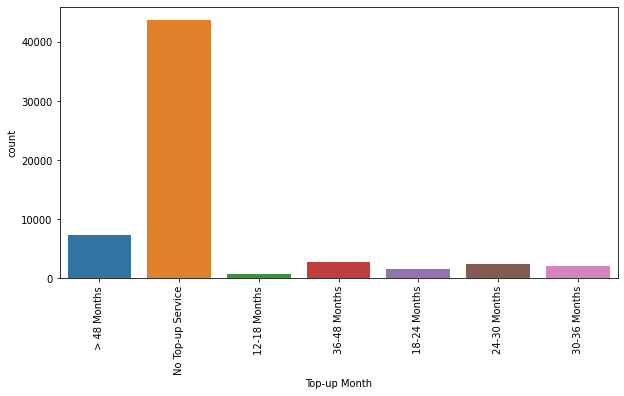

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.countplot(x=train_merged_data['Top-up Month']);

In [ ]:
train_merged_data['Top-up Month'].value_counts()/len(train_merged_data)

No Top-up Service    0.719619
 > 48 Months         0.120455
36-48 Months         0.044784
24-30 Months         0.038781
30-36 Months         0.035607
18-24 Months         0.027581
12-18 Months         0.013174
Name: Top-up Month, dtype: float64

#### Feature Selection

In [ ]:
train_merged_data.shape , test_merged_data.shape

((60803, 288), (7816, 278))

# Removing few features:

>  Removing all of the date features

>  Removing HIST features, because we have already extracted information from these

>  Removing features after running adversial validation. These features has different distribution in train and test file.

In [ ]:
features_to_remove = [  
    'DisbursalDate', 
    'AuthDate',
    'DATE-REPORTED', 
    'DISBURSED-DT',
    'CLOSE-DT', 
    'LAST-PAYMENT-DATE', 
    'INSTALLMENT-FREQUENCY', 
    'REPORTED DATE - HIST', 
    'DPD - HIST', 
    'CUR BAL - HIST',
    'AMT OVERDUE - HIST', 
    'AMT PAID - HIST', 
    'AmountFinance', #Similar like DisbursalAmount
    'TENURE',
    
      #Removing these features: find out after running adversial validation
     'City', 
     'Area', 
     'AssetID', 
     'ZiPCODE', 
     'BranchID', 
     'ManufacturerID', 
     'State', 
     'ID', 
     'MaturityDAte',
     'SupplierID',
                      
]
X = train_merged_data.drop(['Top-up Month'] + features_to_remove, axis=1)
y = train_merged_data['Top-up Month']
X.shape, y.shape

((60803, 263), (60803,))

In [ ]:
XTEST = test_merged_data.drop(features_to_remove, axis=1)

In [ ]:
XTEST.shape

(7816, 254)

# Feature Engineering: 

> Added feature after finding how much loan repaid after different time-intervals :

    like till 18 months, till 24 months, etc...

In [ ]:
loan_payment_freq_mapping = {
    'Monthly' : 1,
    'Quatrly': 3,
    'Half Yearly': 6,
    'BI-Monthly': 2
}

compound_interest_n_mapping = {
    'Monthly' : 12,
    'Quatrly': 4,
    'Half Yearly': 2,
    'BI-Monthly': 6
    
}
def loan_repayment_12_18(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 18:
        loan_repaid = emi * (18 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_24(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])

    if tenure >= 24:
        loan_repaid = emi * (24 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_30(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 30:
        loan_repaid = emi * (30 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_36(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 36:
        loan_repaid = emi * (36 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_48(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 48:
        loan_repaid = emi * (48 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

In [ ]:
X.shape , XTEST.shape

((60803, 263), (7816, 254))

In [ ]:
X['loan_repaid_upto_18_months'] = X.apply(loan_repayment_12_18, axis=1)
XTEST['loan_repaid_upto_18_months'] = XTEST.apply(loan_repayment_12_18, axis=1)

X['loan_repaid_upto_24_months'] = X.apply(loan_repayment_upto_24, axis=1)
XTEST['loan_repaid_upto_24_months'] = XTEST.apply(loan_repayment_upto_24, axis=1)

X['loan_repaid_upto_30_months'] = X.apply(loan_repayment_upto_30, axis=1)
XTEST['loan_repaid_upto_30_months'] = XTEST.apply(loan_repayment_upto_30, axis=1)

X['loan_repaid_upto_36_months'] = X.apply(loan_repayment_upto_36, axis=1)
XTEST['loan_repaid_upto_36_months'] = XTEST.apply(loan_repayment_upto_36, axis=1)

X['loan_repaid_upto_48_months'] = X.apply(loan_repayment_upto_48, axis=1)
XTEST['loan_repaid_upto_48_months'] = XTEST.apply(loan_repayment_upto_48, axis=1)

In [ ]:
display(X.head())
display(XTEST.head())

Frequency InstlmentMode LoanStatus   PaymentMode  Tenure  AssetCost  \
2    Monthly        Arrear     Closed           PDC      48     450000   
15   Monthly       Advance     Closed           PDC      47     485000   
36   Quatrly        Arrear     Active  Direct Debit      68     690000   
56   Monthly       Advance     Closed        Billed      48     480000   
61   Monthly        Arrear     Closed        Billed      44     619265   

    DisbursalAmount      EMI    LTV SEX   AGE  MonthlyIncome  \
2          275000.0  24000.0  61.11   M  49.0       35833.33   
15         350000.0  10500.0  70.00   M  23.0         666.67   
36         519728.0  38300.0  69.77   M  39.0       45257.00   
56         400000.0  11600.0  80.92   M  24.0       20833.33   
61         440000.0  15000.0  71.05   M  56.0       27313.67   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
2                           200000                         30000   
15                          300000                           600   
36                          500000                         40000   
56                          400000                         20000   
61                          400000                         20000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
2                   40                     40               20000   
15                  20                     40               10000   
36                  30                     60               30000   
56                  20                     40               10000   
61                  50                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
2                     400000                       2                     4   
15                    400000                       4                     0   
36                    600000                       9                     6   
56                    400000                       6                     1   
61                    600000                       7                     3   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
2            7              4           1           5                 0   
15           0              3           0           7                 1   
36           4              6           3           7                 9   
56           0              4           0           9                 1   
61           8              3           1           7                 7   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
2                      False           False           False   
15                     False           False           False   
36                     False           False           False   
56                     False           False           False   
61                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
2                        False                 False           False   
15                       False                 False           False   
36                       False                 False           False   
56                       False                 False           False   
61                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
2               False                     53.0         0.669768   
15              False                     26.0        15.749921   
36              False                     44.0         0.846278   
56              False                     28.0         0.556800   
61              False                     59.0         0.549176   

    SELF-INDICATOR MATCH-TYPE     ACCT-TYPE CONTRIBUTOR-TYPE OWNERSHIP-IND  \
2             True    PRIMARY  Tractor Loan              NBF    Individual   
15            True    PRIMARY  Tractor Loan         

Frequency InstlmentMode LoanStatus   PaymentMode  Tenure  AssetCost  \
3    Monthly       Advance     Closed           PDC      46     480000   
8    Monthly       Advance     Closed           PDC      45     480000   
22   Quatrly        Arrear     Closed           PDC      48     580000   
29   Quatrly        Arrear     Active  Direct Debit      48     636000   
36   Monthly        Arrear     Closed           ECS      48     598000   

    DisbursalAmount      EMI    LTV SEX   AGE  MonthlyIncome Top-up Month  \
3          365000.0   1000.0  75.83   M  50.0       32069.00          NaN   
8          285000.0   9300.0  57.44   M  35.0       25000.00          NaN   
22         400000.0  35800.0  68.97   M  37.0       23333.33          NaN   
29         400000.0  35300.0  57.34   F  49.0       41666.67          NaN   
36         350000.0  10261.0  56.81   M  31.0       33333.33          NaN   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
3                           300000                         30000   
8                           200000                         20000   
22                          400000                         20000   
29                          400000                         40000   
36                          300000                         30000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
3                   50                     40                1000   
8                   30                     40                9000   
22                  30                     40               30000   
29                  40                     40               30000   
36                  30                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
3                     400000                       5                     3   
8                     400000                       2                     2   
22                    500000                       6                     1   
29                    600000                       6                     5   
36                    500000                       4                     4   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
3            7              3           0           8                 1   
8            3              3           0           4                 1   
22           4              4           2           6                 6   
29           7              4           2           4                 8   
36           2              4           0           3                 6   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
3                      False           False           False   
8                      False           False           False   
22                     False           False           False   
29                     False           False           False   
36                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
3                        False                 False           False   
8                        False                 False           False   
22                       False                 False           False   
29                       False                 False           False   
36                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
3               False                     53.0         0.031183   
8               False                     38.0         0.372000   
22              False                     41.0         1.534286   
29              False                     53.0         0.847200   
36              False                     35.0         0.307830   

    SELF-INDICATOR MATCH-TYPE     ACCT-TYPE CONTRIBUTOR-TYPE OWNERSHIP-IND  \
3             True    PRIMARY  Tractor Loan         

In [ ]:
X.shape  , XTEST.shape

((60803, 268), (7816, 259))

### Target and Categorical Encoding

In [ ]:
target_encoder = LabelEncoder()
y_trans= target_encoder.fit_transform(y)
y_trans

array([0, 6, 1, ..., 6, 2, 2])

In [ ]:
for col in X.select_dtypes('object'):
    print("Encoding :", col)
    le = LabelEncoder()
    le.fit(list(X[col]) + list(XTEST[col]))
    X[col] = le.transform(X[col])
    XTEST[col] = le.transform(XTEST[col])

Encoding : Frequency
Encoding : InstlmentMode
Encoding : LoanStatus
Encoding : PaymentMode
Encoding : SEX
Encoding : MATCH-TYPE
Encoding : ACCT-TYPE
Encoding : CONTRIBUTOR-TYPE
Encoding : OWNERSHIP-IND
Encoding : ACCOUNT-STATUS
Encoding : ASSET_CLASS
Encoding : NEXT_LOAN_BUCKET


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60803 entries, 2 to 556965
Columns: 268 entries, Frequency to loan_repaid_upto_48_months
dtypes: bool(9), float64(138), int64(121)
memory usage: 123.6 MB


In [ ]:
XTEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7816 entries, 3 to 63258
Columns: 259 entries, Frequency to loan_repaid_upto_48_months
dtypes: bool(9), float64(139), int64(110), object(1)
memory usage: 15.0+ MB


In [ ]:
X.shape, XTEST.shape

((60803, 268), (7816, 259))

Now we can clearly see some features which are missing in test

In [ ]:
features_missing_from_test_data = set(X.columns) - set(XTEST.columns)
features_missing_from_test_data

{'ACCOUNT-STATUS___WILFUL DEFAULT___COUNT',
 'ACCT-TYPE___Business Non-Funded Credit Facility-Priority Sector-Others___COUNT',
 'ACCT-TYPE___Commercial Equipment Loan___COUNT',
 'ACCT-TYPE___Corporate Credit Card___COUNT',
 'ACCT-TYPE___Fleet Card___COUNT',
 'ACCT-TYPE___JLG Group___COUNT',
 'ACCT-TYPE___Loan on Credit Card___COUNT',
 'ACCT-TYPE___Pradhan Mantri Awas Yojana - CLSS___COUNT',
 'ACCT-TYPE___SHG Group___COUNT',
 'ASSET_CLASS___2___COUNT',
 'CONTRIBUTOR-TYPE___ARC___COUNT'}

In [ ]:
XTEST[list(features_missing_from_test_data)] = 0
XTEST.head()

Frequency  InstlmentMode  LoanStatus  PaymentMode  Tenure  AssetCost  \
3           2              0           1            6      46     480000   
8           2              0           1            6      45     480000   
22          3              1           1            6      48     580000   
29          3              1           0            3      48     636000   
36          2              1           1            4      48     598000   

    DisbursalAmount      EMI    LTV  SEX   AGE  MonthlyIncome Top-up Month  \
3          365000.0   1000.0  75.83    1  50.0       32069.00          NaN   
8          285000.0   9300.0  57.44    1  35.0       25000.00          NaN   
22         400000.0  35800.0  68.97    1  37.0       23333.33          NaN   
29         400000.0  35300.0  57.34    0  49.0       41666.67          NaN   
36         350000.0  10261.0  56.81    1  31.0       33333.33          NaN   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
3                           300000                         30000   
8                           200000                         20000   
22                          400000                         20000   
29                          400000                         40000   
36                          300000                         30000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
3                   50                     40                1000   
8                   30                     40                9000   
22                  30                     40               30000   
29                  40                     40               30000   
36                  30                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
3                     400000                       5                     3   
8                     400000                       2                     2   
22                    500000                       6                     1   
29                    600000                       6                     5   
36                    500000                       4                     4   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
3            7              3           0           8                 1   
8            3              3           0           4                 1   
22           4              4           2           6                 6   
29           7              4           2           4                 8   
36           2              4           0           3                 6   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
3                      False           False           False   
8                      False           False           False   
22                     False           False           False   
29                     False           False           False   
36                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
3                        False                 False           False   
8                        False                 False           False   
22                       False                 False           False   
29                       False                 False           False   
36                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
3               False                     53.0         0.031183   
8               False                     38.0         0.372000   
22              False                     41.0         1.534286   
29              False                     53.0         0.847200   
36              False                     35.0         0.307830   

    SELF-INDICATOR  MATCH-TYPE  ACCT-TYPE  CONTRIBUTOR-TYPE  OWNERSHIP-IND  \
3             True           0     

In [ ]:
XTEST = XTEST[X.columns]
XTEST.head()

Frequency  InstlmentMode  LoanStatus  PaymentMode  Tenure  AssetCost  \
3           2              0           1            6      46     480000   
8           2              0           1            6      45     480000   
22          3              1           1            6      48     580000   
29          3              1           0            3      48     636000   
36          2              1           1            4      48     598000   

    DisbursalAmount      EMI    LTV  SEX   AGE  MonthlyIncome  \
3          365000.0   1000.0  75.83    1  50.0       32069.00   
8          285000.0   9300.0  57.44    1  35.0       25000.00   
22         400000.0  35800.0  68.97    1  37.0       23333.33   
29         400000.0  35300.0  57.34    0  49.0       41666.67   
36         350000.0  10261.0  56.81    1  31.0       33333.33   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
3                           300000                         30000   
8                           200000                         20000   
22                          400000                         20000   
29                          400000                         40000   
36                          300000                         30000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
3                   50                     40                1000   
8                   30                     40                9000   
22                  30                     40               30000   
29                  40                     40               30000   
36                  30                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
3                     400000                       5                     3   
8                     400000                       2                     2   
22                    500000                       6                     1   
29                    600000                       6                     5   
36                    500000                       4                     4   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
3            7              3           0           8                 1   
8            3              3           0           4                 1   
22           4              4           2           6                 6   
29           7              4           2           4                 8   
36           2              4           0           3                 6   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
3                      False           False           False   
8                      False           False           False   
22                     False           False           False   
29                     False           False           False   
36                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
3                        False                 False           False   
8                        False                 False           False   
22                       False                 False           False   
29                       False                 False           False   
36                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
3               False                     53.0         0.031183   
8               False                     38.0         0.372000   
22              False                     41.0         1.534286   
29              False                     53.0         0.847200   
36              False                     35.0         0.307830   

    SELF-INDICATOR  MATCH-TYPE  ACCT-TYPE  CONTRIBUTOR-TYPE  OWNERSHIP-IND  \
3             True           0         26                 6              1   
8             True           0     

In [ ]:
X.shape, XTEST.shape

((60803, 268), (7816, 268))

In [ ]:
display(X.head())
display(XTEST.head())

Frequency  InstlmentMode  LoanStatus  PaymentMode  Tenure  AssetCost  \
2           2              1           1            6      48     450000   
15          2              0           1            6      47     485000   
36          3              1           0            3      68     690000   
56          2              0           1            1      48     480000   
61          2              1           1            1      44     619265   

    DisbursalAmount      EMI    LTV  SEX   AGE  MonthlyIncome  \
2          275000.0  24000.0  61.11    1  49.0       35833.33   
15         350000.0  10500.0  70.00    1  23.0         666.67   
36         519728.0  38300.0  69.77    1  39.0       45257.00   
56         400000.0  11600.0  80.92    1  24.0       20833.33   
61         440000.0  15000.0  71.05    1  56.0       27313.67   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
2                           200000                         30000   
15                          300000                           600   
36                          500000                         40000   
56                          400000                         20000   
61                          400000                         20000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
2                   40                     40               20000   
15                  20                     40               10000   
36                  30                     60               30000   
56                  20                     40               10000   
61                  50                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
2                     400000                       2                     4   
15                    400000                       4                     0   
36                    600000                       9                     6   
56                    400000                       6                     1   
61                    600000                       7                     3   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
2            7              4           1           5                 0   
15           0              3           0           7                 1   
36           4              6           3           7                 9   
56           0              4           0           9                 1   
61           8              3           1           7                 7   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
2                      False           False           False   
15                     False           False           False   
36                     False           False           False   
56                     False           False           False   
61                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
2                        False                 False           False   
15                       False                 False           False   
36                       False                 False           False   
56                       False                 False           False   
61                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
2               False                     53.0         0.669768   
15              False                     26.0        15.749921   
36              False                     44.0         0.846278   
56              False                     28.0         0.556800   
61              False                     59.0         0.549176   

    SELF-INDICATOR  MATCH-TYPE  ACCT-TYPE  CONTRIBUTOR-TYPE  OWNERSHIP-IND  \
2             True           0         26                 6              1   
15            True           0     

Frequency  InstlmentMode  LoanStatus  PaymentMode  Tenure  AssetCost  \
3           2              0           1            6      46     480000   
8           2              0           1            6      45     480000   
22          3              1           1            6      48     580000   
29          3              1           0            3      48     636000   
36          2              1           1            4      48     598000   

    DisbursalAmount      EMI    LTV  SEX   AGE  MonthlyIncome  \
3          365000.0   1000.0  75.83    1  50.0       32069.00   
8          285000.0   9300.0  57.44    1  35.0       25000.00   
22         400000.0  35800.0  68.97    1  37.0       23333.33   
29         400000.0  35300.0  57.34    0  49.0       41666.67   
36         350000.0  10261.0  56.81    1  31.0       33333.33   

    DisbursalAmount___WHOLE_NUMBER  MonthlyIncome___WHOLE_NUMBER  \
3                           300000                         30000   
8                           200000                         20000   
22                          400000                         20000   
29                          400000                         40000   
36                          300000                         30000   

    AGE___WHOLE_NUMBER  Tenure___WHOLE_NUMBER  EMI___WHOLE_NUMBER  \
3                   50                     40                1000   
8                   30                     40                9000   
22                  30                     40               30000   
29                  40                     40               30000   
36                  30                     40               10000   

    AssetCost___WHOLE_NUMBER  DisbursalAmount___BINS  MonthlyIncome___BINS  \
3                     400000                       5                     3   
8                     400000                       2                     2   
22                    500000                       6                     1   
29                    600000                       6                     5   
36                    500000                       4                     4   

    AGE___BINS  Tenure___BINS  EMI___BINS  LTV___BINS  AssetCost___BINS  \
3            7              3           0           8                 1   
8            3              3           0           4                 1   
22           4              4           2           6                 6   
29           7              4           2           4                 8   
36           2              4           0           3                 6   

    MonthlyIncome___OUTLIERS  AGE___OUTLIERS  EMI___OUTLIERS  \
3                      False           False           False   
8                      False           False           False   
22                     False           False           False   
29                     False           False           False   
36                     False           False           False   

    DisbursalAmount___OUTLIERS  AssetCost___OUTLIERS  LTV___OUTLIERS  \
3                        False                 False           False   
8                        False                 False           False   
22                       False                 False           False   
29                       False                 False           False   
36                       False                 False           False   

    Tenure___OUTLIERS  AGE_WHEN_LOAN_COMPLETES  EMI_INCOME_RATO  \
3               False                     53.0         0.031183   
8               False                     38.0         0.372000   
22              False                     41.0         1.534286   
29              False                     53.0         0.847200   
36              False                     35.0         0.307830   

    SELF-INDICATOR  MATCH-TYPE  ACCT-TYPE  CONTRIBUTOR-TYPE  OWNERSHIP-IND  \
3             True           0         26                 6              1   
8             True           0     

# Benchmarking different models:

> LGB

> XGB

> Ensmeble : 0.5* LGB + 0.5 * XGB

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_trans, test_size=0.2, random_state=SEED, stratify=y_trans)

In [ ]:
current_best = (0.5904478029251055, {'bagging_fraction': 0.9648178267940851, 'bagging_freq': 5, 'feature_fraction': 0.7864711972326701, 'lambda_l1': 0.05, 'lambda_l2': 3.3000000000000003, 'learning_rate': 0.025, 'max_bin': 255, 'max_depth': 15, 'metric': 'multi_logloss', 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 5.068990408995694, 'num_class': 7, 'num_leaves': 21, 'objective': 'multiclass', 'seed': 2021, 'verbose': -1}, 372)
    

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [ ]:
param = current_best[1].copy()
param

{'bagging_fraction': 0.9648178267940851,
 'bagging_freq': 5,
 'feature_fraction': 0.7864711972326701,
 'lambda_l1': 0.05,
 'lambda_l2': 3.3000000000000003,
 'learning_rate': 0.025,
 'max_bin': 255,
 'max_depth': 15,
 'metric': 'multi_logloss',
 'min_data_in_leaf': 92,
 'min_sum_hessian_in_leaf': 5.068990408995694,
 'num_class': 7,
 'num_leaves': 21,
 'objective': 'multiclass',
 'seed': 2021,
 'verbose': -1}

In [ ]:
bst = lgb.train(param, train_data, NUM_OF_BOOST_ROUND, 
                valid_sets=[train_data, valid_data], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)

Training until validation scores don't improve for 300 rounds.
[100]	training's multi_logloss: 0.494225	valid_1's multi_logloss: 0.518642
[200]	training's multi_logloss: 0.429025	valid_1's multi_logloss: 0.471722
[300]	training's multi_logloss: 0.396624	valid_1's multi_logloss: 0.458752
[400]	training's multi_logloss: 0.372807	valid_1's multi_logloss: 0.453695
[500]	training's multi_logloss: 0.35308	valid_1's multi_logloss: 0.450912
[600]	training's multi_logloss: 0.336083	valid_1's multi_logloss: 0.449673
[700]	training's multi_logloss: 0.320858	valid_1's multi_logloss: 0.449001
[800]	training's multi_logloss: 0.307051	valid_1's multi_logloss: 0.448803
[900]	training's multi_logloss: 0.29398	valid_1's multi_logloss: 0.448658
[1000]	training's multi_logloss: 0.282069	valid_1's multi_logloss: 0.448569
[1100]	training's multi_logloss: 0.270665	valid_1's multi_logloss: 0.448893
[1200]	training's multi_logloss: 0.259915	valid_1's multi_logloss: 0.449307
[1300]	training's multi_logloss: 0.2

In [ ]:
# Predict Validation
ypred_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
f1_score(y_valid, np.argmax(ypred_valid, axis=1), average='macro')

0.6675666677915275

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, np.argmax(ypred_valid, axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.66      0.72      1465
           1       0.66      0.39      0.49       160
           2       0.74      0.53      0.62       335
           3       0.76      0.58      0.65       472
           4       0.79      0.56      0.65       433
           5       0.76      0.52      0.62       545
           6       0.88      0.96      0.92      8751

    accuracy                           0.86     12161
   macro avg       0.77      0.60      0.67     12161
weighted avg       0.85      0.86      0.85     12161



In [ ]:
f_importance_df = pd.DataFrame(bst.feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

In [ ]:
top_features = f_importance_df['importance'][:30].index
top_features

Index(['CUR_BAL_HIST_TOTAL', 'MonthlyIncome', 'LTV', 'EMI_INCOME_RATO',
       'AssetCost', 'EMI', 'CUR_BAL_HIST_TOTAL___LESS_THAN_12_BUCKET___MEAN',
       'OLD_NEW_LOAN_RATIO____MEAN_PER_CUSTOMER', 'NEXT_LOAN_IN_MONTHS',
       'ACCT-TYPE___Gold Loan___COUNT',
       'CUR_BAL_HIST_TOTAL____MEAN_PER_CUSTOMER', 'CURRENT-BAL',
       'AMT_OVERDUE_HIST_TOTAL____MEAN_PER_CUSTOMER',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT____MEAN_PER_CUSTOMER',
       'DisbursalAmount', 'CURRENT-BAL____MEAN_PER_CUSTOMER',
       'DISBURSED-AMT/HIGH CREDIT____MEAN_PER_CUSTOMER', 'Tenure',
       'CURRENT-BAL___WHOLE_NUMBER____MEAN_PER_CUSTOMER',
       'AGE_WHEN_LOAN_COMPLETES', 'AGE',
       'AMT_OVERDUE_HIST_TOTAL___LESS_THAN_12_BUCKET___MEAN',
       'DISBURSED-AMT/HIGH CREDIT___LESS_THAN_12_BUCKET___MEAN',
       'AMT_PAID_HIST_TOTAL____MEAN_PER_CUSTOMER',
       'DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER____MEAN_PER_CUSTOMER',
       'CURRENT-BAL___LESS_THAN_12_BUCKET___MEAN', 'PaymentMode'

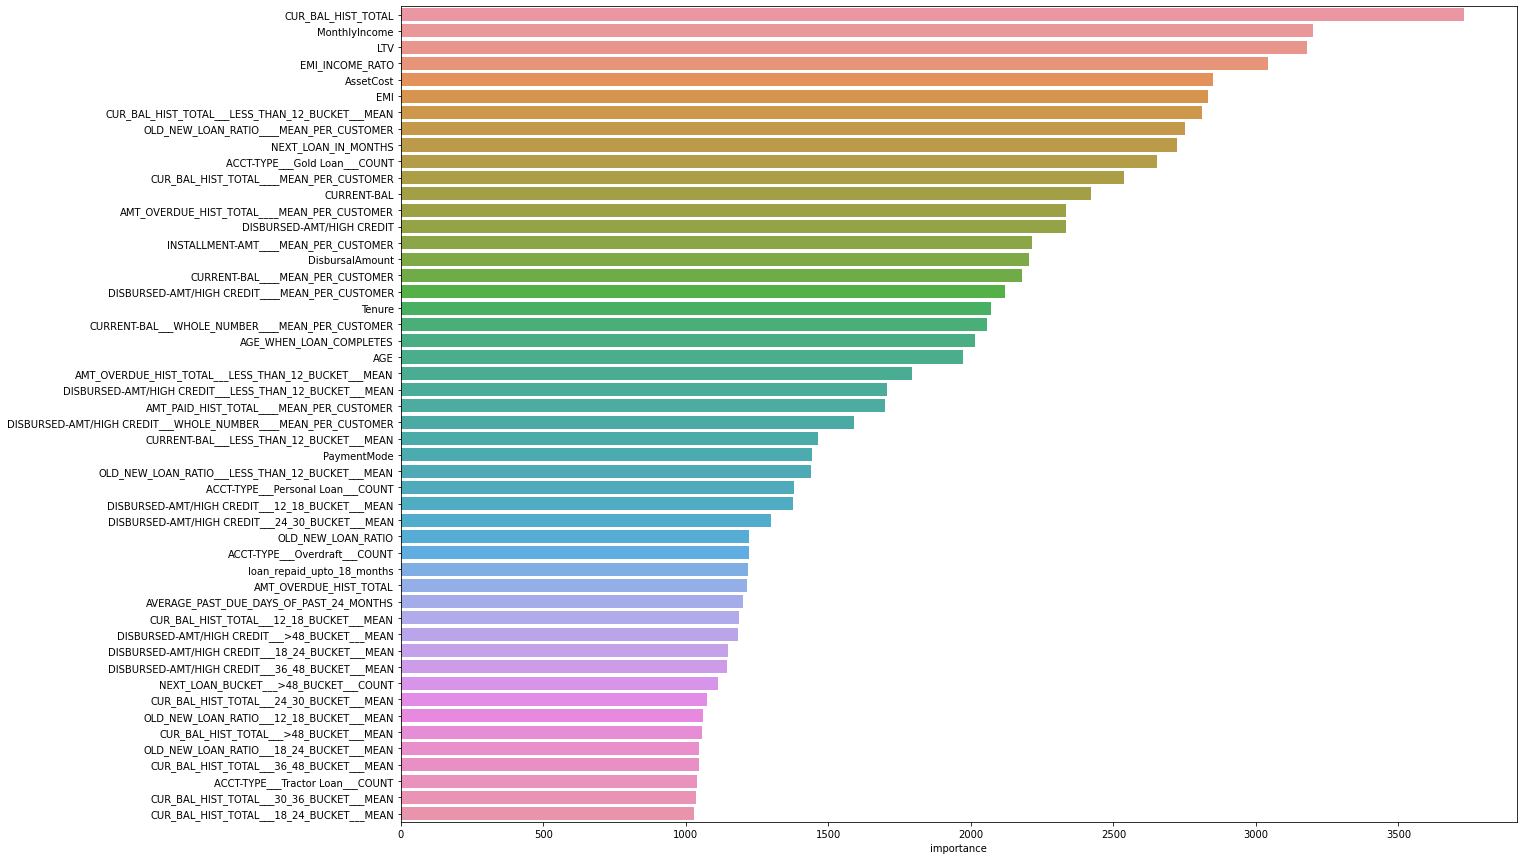

In [ ]:
plt.figure(figsize=(20,15))
sns.barplot(x=f_importance_df.importance[:50], y=f_importance_df.index[:50]);

# XGB

In [ ]:
xgb_train_data = xgb.DMatrix(X_train, label=y_train)
xgb_valid_data = xgb.DMatrix(X_valid, label=y_valid)
xgb_current_best = (0.5992587341153869, {'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.45, 'eval_metric': 'mlogloss', 'gamma': 0.75, 'max_depth': 5, 'min_child_weight': 4.0, 'num_class': 7, 'objective': 'multi:softprob', 'reg_alpha': 0.1, 'reg_lambda': 1.9000000000000001, 'seed': 2021, 'silent': 1, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}, 30)
xgb_params = xgb_current_best[1].copy()
xgb_bst = xgb.train(xgb_params, xgb_train_data, NUM_OF_BOOST_ROUND, 
                evals=[(xgb_train_data, 'train'), (xgb_valid_data, 'eval')], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)

[15:43:52] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.06147	eval-mlogloss:1.06754
[100]	train-mlogloss:0.23650	eval-mlogloss:0.46171
[200]	train-mlogloss:0.14870	eval-mlogloss:0.47708
[300]	train-mlogloss:0.10912	eval-mlogloss:0.48939
[349]	train-mlogloss:0.09800	eval-mlogloss:0.49310


In [ ]:
xgb_ypred_valid = xgb_bst.predict(xgb_valid_data, ntree_limit=xgb_bst.best_ntree_limit)
f1_score(y_valid, np.argmax(xgb_ypred_valid, axis=1), average='macro')

0.6687140225696764

In [ ]:
ensemble_ypred_valid = 0.5 * ypred_valid + 0.5 * xgb_ypred_valid
f1_score(y_valid, np.argmax(ensemble_ypred_valid, axis=1), average='macro')

0.6705701847072769

# OOF (Out Of Fold) Prediction:

![Model_with_selected_features](https://github.com/asingleneuron/edgeverve_ml_challenge/blob/master/images/OOF_PREDICTION.png?raw=True)

In [ ]:
if OOF_PREDICTION:
    best_param = current_best[1]
    xgb_params = xgb_current_best[1].copy()

    
    num_splits = NUM_OF_SPLITS
    skf = StratifiedKFold(n_splits= num_splits, random_state=SEED, shuffle=False)
    oof_predictions = np.zeros((X.shape[0], 7)) 

    y_test_pred = np.zeros((XTEST.shape[0], 7)) 
    y_test_pred_xgb = np.zeros((XTEST.shape[0], 7)) 
    y_test_pred_ensemble = np.zeros((XTEST.shape[0], 7)) 
    

    print(y_test_pred.shape)
    y_valid_scores = []
    y_valid_scores_xgb = []
    y_valid_scores_ensemble = []

    fold_cnt = 1
    for train_index, test_index in skf.split(X,y_trans):
        print("FOLD .... ",fold_cnt)
        fold_cnt += 1

        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y_trans[train_index], y_trans[test_index]
        
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        # Training lgb model
        num_round = NUM_OF_BOOST_ROUND
        bst = lgb.train(best_param, dtrain, num_round,
                              valid_sets=[dtrain, dvalid],
                              verbose_eval=100,
                              early_stopping_rounds=EARLY_STOPPING,
#                               feval=F1_MACRO
                             )
        # Predict Validation
        y_pred_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
        y_valid_scores.append(f1_score(y_valid, np.argmax(y_pred_valid, axis=1), average='macro'))

        # Predict Test 
        y_pred = bst.predict(XTEST, num_iteration=bst.best_iteration)

        y_test_pred += y_pred
        
        #XGB
        xgb_train_data = xgb.DMatrix(X_train, label=y_train)
        xgb_valid_data = xgb.DMatrix(X_valid, label=y_valid)
        xgb_params = xgb_current_best[1].copy()
        xgb_bst = xgb.train(xgb_params, xgb_train_data, NUM_OF_BOOST_ROUND, 
                evals=[(xgb_train_data, 'train'), (xgb_valid_data, 'eval')], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)
        xgb_ypred_valid = xgb_bst.predict(xgb_valid_data, ntree_limit=xgb_bst.best_ntree_limit)
        y_valid_scores_xgb.append(f1_score(y_valid, np.argmax(xgb_ypred_valid, axis=1), average='macro'))
        y_pred_xgb = xgb_bst.predict(xgb.DMatrix(XTEST), ntree_limit=xgb_bst.best_ntree_limit)
        y_test_pred_xgb += y_pred_xgb
        
        #Ensemble
        ypred_ensemble = 0.5 * y_pred_valid + 0.5 * xgb_ypred_valid
        y_valid_scores_ensemble.append(f1_score(y_valid, np.argmax(ypred_ensemble, axis=1), average='macro'))
        y_test_pred_ensemble += (0.5 * y_test_pred + 0.5 * y_test_pred_xgb)


    #Normalize test predicted probability
    y_test_pred /= num_splits
    y_test_pred_xgb /= num_splits
    y_test_pred_ensemble /= num_splits

(7816, 7)
FOLD ....  1
Training until validation scores don't improve for 300 rounds
[100]	training's multi_logloss: 0.439789	valid_1's multi_logloss: 0.51856
[200]	training's multi_logloss: 0.384862	valid_1's multi_logloss: 0.497795
[300]	training's multi_logloss: 0.351318	valid_1's multi_logloss: 0.494807
[400]	training's multi_logloss: 0.324702	valid_1's multi_logloss: 0.494391
[500]	training's multi_logloss: 0.301714	valid_1's multi_logloss: 0.495003
[600]	training's multi_logloss: 0.281323	valid_1's multi_logloss: 0.496372
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.337628	valid_1's multi_logloss: 0.494037
[15:47:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.05362	eva

In [ ]:
print(y_valid_scores)
print("Average validation_score: ",np.mean(y_valid_scores))

[0.6208384511101811, 0.6503458561467355, 0.7193687335823485, 0.7107993639396764, 0.6843931095614735]
Average validation_score:  0.6771491028680829


In [ ]:
print(y_valid_scores_xgb)
print("Average validation_score: ",np.mean(y_valid_scores_xgb))

[0.6104589410019703, 0.6397169459190339, 0.7106621462035809, 0.7010919166427253, 0.6801322749532864]
Average validation_score:  0.6684124449441193


In [ ]:
print(y_valid_scores_ensemble)
print("Average validation_score: ",np.mean(y_valid_scores_ensemble))

[0.6182841655206124, 0.6495814673223056, 0.7161323027945168, 0.7083211854785336, 0.6823117114202334]
Average validation_score:  0.6749261665072404


In [ ]:
ytest_lgb_target = target_encoder.inverse_transform(np.argmax(y_test_pred, axis=1))
ytest_xgb_target = target_encoder.inverse_transform(np.argmax(y_test_pred_xgb, axis=1))
ytest_ens_target = target_encoder.inverse_transform(np.argmax(y_test_pred_ensemble, axis=1))


In [ ]:
dummy = test_merged_data[['ID']].copy()
dummy['lgb_pred'] = ytest_lgb_target
dummy['xgb_pred'] = ytest_xgb_target
dummy['ensemble_pred'] = ytest_ens_target

dummy = dummy.set_index(['ID'])
dummy.head()

lgb_pred           xgb_pred      ensemble_pred
ID                                                          
4    No Top-up Service  No Top-up Service  No Top-up Service
5    No Top-up Service        > 48 Months  No Top-up Service
6    No Top-up Service  No Top-up Service  No Top-up Service
126  No Top-up Service  No Top-up Service  No Top-up Service
127  No Top-up Service  No Top-up Service  No Top-up Service

In [ ]:
def get_target(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['lgb_pred']
    else:
        return "No Top-up Service"

def get_target_xgb(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['xgb_pred']
    else:
        return "No Top-up Service"
    
def get_target_ensemble(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['ensemble_pred']
    else:
        return "No Top-up Service"
    

# LGB

In [ ]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("lgb_submission.csv", index=False)

No Top-up Service    13648
 > 48 Months           554
36-48 Months           184
18-24 Months            98
30-36 Months            97
24-30 Months            94
12-18 Months            70
Name: Top-up Month, dtype: int64

No Top-up Service    0.925602
 > 48 Months         0.037572
36-48 Months         0.012479
18-24 Months         0.006646
30-36 Months         0.006579
24-30 Months         0.006375
12-18 Months         0.004747
Name: Top-up Month, dtype: float64


# XGB

In [ ]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target_xgb)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("xgb_submission.csv", index=False)

No Top-up Service    13666
 > 48 Months           558
36-48 Months           172
18-24 Months            97
30-36 Months            95
24-30 Months            88
12-18 Months            69
Name: Top-up Month, dtype: int64

No Top-up Service    0.926823
 > 48 Months         0.037843
36-48 Months         0.011665
18-24 Months         0.006579
30-36 Months         0.006443
24-30 Months         0.005968
12-18 Months         0.004680
Name: Top-up Month, dtype: float64


# Ensemble

In [ ]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target_ensemble)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("ensemble_submission.csv", index=False)

No Top-up Service    13659
 > 48 Months           567
36-48 Months           172
18-24 Months            96
24-30 Months            93
30-36 Months            92
12-18 Months            66
Name: Top-up Month, dtype: int64

No Top-up Service    0.926348
 > 48 Months         0.038454
36-48 Months         0.011665
18-24 Months         0.006511
24-30 Months         0.006307
30-36 Months         0.006239
12-18 Months         0.004476
Name: Top-up Month, dtype: float64
